## Problem Statement - Fraud Detection using Stacking Ensemble Learning


The purpose is to identify the fraudulent transactions in the highly popular Credit card data set,  using ensemble learning - Stacking method. 

This is a subset of the transactions made using credit cards in September 2013 by european cardholders. It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### What is Stacking?

Stacking or Stacked Generalization is an ensemble machine learning algorithm.It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

The benefit of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

### Architecture

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

- Base-Models: Models fit on the training data and whose predictions are compiled.
- Meta-Model: Model that learns how to best combine the predictions of the base models.

The meta-model is trained on the predictions made by base models on out-of-sample data. That is, data not used to train the base models is fed to the base models, predictions are made, and these predictions, along with the expected outputs, provide the input and output pairs of the training dataset used to fit the meta-model.  The outputs from the base models used as input to the meta-model may be real value in the case of regression, and probability values, probability like values, or class labels in the case of classification. 

The most common approach to preparing the training dataset for the meta-model is via k-fold cross-validation of the base models, where the out-of-fold predictions are used as the basis for the training dataset for the meta-model.
The training data for the meta-model may also include the inputs to the base models, e.g. input elements of the training data. This can provide an additional context to the meta-model as to how to best combine the predictions from the meta-model.
Once the training dataset is prepared for the meta-model, the meta-model can be trained in isolation on this dataset, and the base-models can be trained on the entire original training dataset.

### Best algorithm Selection

The objective is to get accurate predictions of the target variable, with the most relevant explanatory variables. Stacking utilizes the strength of each individual model by using their output as input to the final model.

### Best Features Selection

### 1.Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Normalizer, scale
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

### 2.Load the dataset

In [2]:
df = pd.read_csv('creditcard.csv')
#drop unnecessary columns
df.drop('Time',axis=1, inplace=True)
df.shape

(1191, 30)

### 3.Exploratory data anlysis 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      1191 non-null   float64
 1   V2      1191 non-null   float64
 2   V3      1191 non-null   float64
 3   V4      1191 non-null   float64
 4   V5      1191 non-null   float64
 5   V6      1191 non-null   float64
 6   V7      1191 non-null   float64
 7   V8      1191 non-null   float64
 8   V9      1191 non-null   float64
 9   V10     1191 non-null   float64
 10  V11     1191 non-null   float64
 11  V12     1191 non-null   float64
 12  V13     1191 non-null   float64
 13  V14     1191 non-null   float64
 14  V15     1191 non-null   float64
 15  V16     1191 non-null   float64
 16  V17     1191 non-null   float64
 17  V18     1191 non-null   float64
 18  V19     1191 non-null   float64
 19  V20     1191 non-null   float64
 20  V21     1191 non-null   float64
 21  V22     1191 non-null   float64
 22  

All the variables are numerical. V1-V28, Amount are the predictor variables and Class is dependent variable. This information helps a lot when we’re applying different calculations on a column level.

In [4]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,-1.224016,0.942978,-0.690338,1.046707,-0.809904,-0.195756,-1.047084,0.454245,-0.510057,-1.048724,...,0.125966,-0.128940,-0.070197,-0.015527,0.132017,0.037807,0.104899,-0.006757,71.028925,0.162888
std,4.123068,2.578204,4.994825,2.457333,3.174951,1.512986,3.790665,2.495252,1.739402,3.177958,...,0.817318,0.647872,0.727216,0.602504,0.545687,0.460593,0.585943,0.339297,192.026373,0.369419
min,-30.552380,-12.114213,-31.103685,-4.657545,-22.105532,-4.977692,-21.922811,-7.494658,-9.283925,-18.271168,...,-4.134608,-2.776923,-19.254328,-1.867208,-4.781606,-1.243924,-3.908080,-2.735623,0.000000,0.000000
25%,-1.247088,-0.098080,-0.133344,-0.285854,-0.838137,-0.836937,-0.673663,-0.152539,-0.746082,-0.675266,...,-0.209303,-0.551859,-0.194287,-0.372789,-0.177064,-0.288574,-0.040726,-0.028550,3.790000,0.000000
50%,-0.485238,0.445575,0.639922,0.614899,-0.214256,-0.233421,-0.001112,0.072841,-0.183811,-0.184663,...,-0.050148,-0.093159,-0.056486,0.076211,0.148452,0.013626,0.033931,0.024008,15.800000,0.000000
75%,1.089880,1.104180,1.393512,1.379459,0.405725,0.342190,0.503928,0.400059,0.379457,0.189274,...,0.174052,0.301762,0.084489,0.411450,0.456565,0.296551,0.204157,0.110458,61.905000,0.000000
max,1.685314,16.713389,4.017561,11.927512,7.672544,5.122103,5.431271,20.007208,5.459274,8.821756,...,5.273420,1.745315,3.150413,1.215279,2.208209,3.087444,3.052358,1.575380,3828.040000,1.000000


Summary statistics are there to give overall view of the metrics in the data set at a glance.

They include the count of observations, the mean of observations, the standard deviation, min, 25% quartile, 50% quartile, 75% quartile, and the max value in each Series.

The outputs of summary statistics excludes the categorical variables or string variables.

In [5]:
df.nunique()

V1        1181
V2        1181
V3        1181
V4        1181
V5        1181
V6        1181
V7        1181
V8        1181
V9        1181
V10       1181
V11       1181
V12       1181
V13       1181
V14       1181
V15       1181
V16       1181
V17       1181
V18       1181
V19       1181
V20       1181
V21       1181
V22       1181
V23       1181
V24       1181
V25       1181
V26       1181
V27       1181
V28       1181
Amount     706
Class        2
dtype: int64

Except Class, all the variables are continuous.

In [6]:
#check the missing values
df.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no missing values in the data set.

#### Univariate Analysis

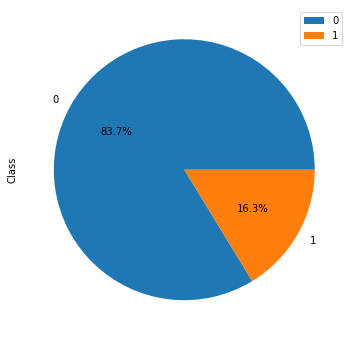

In [7]:
df['Class'].value_counts().plot.pie(legend= True, figsize = (16,6), autopct = '%1.1f%%');

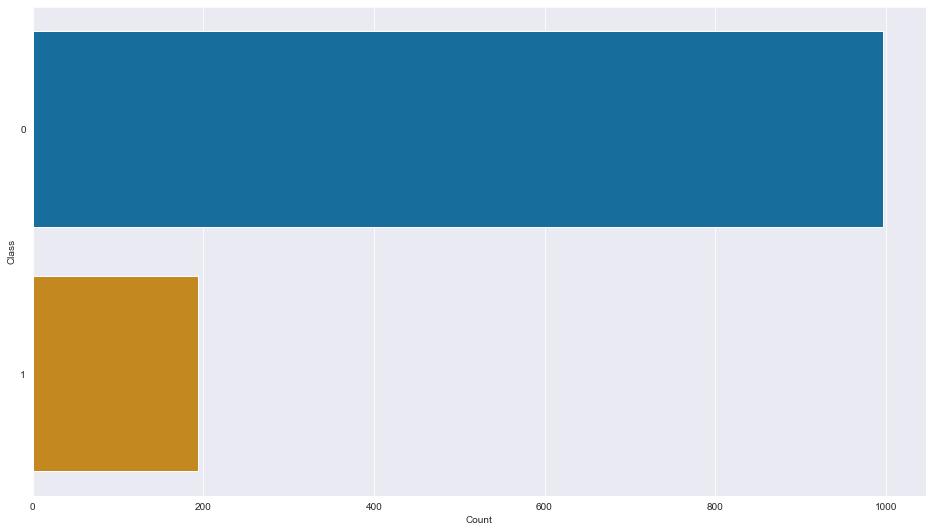

In [8]:
sns.set_style('darkgrid')
sns.countplot(y='Class',data=df,palette='colorblind')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show() 

This is a highly imbalanced data set.

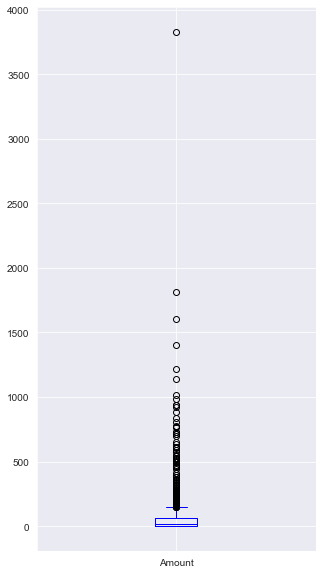

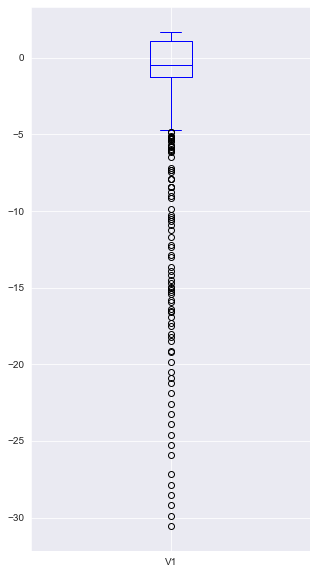

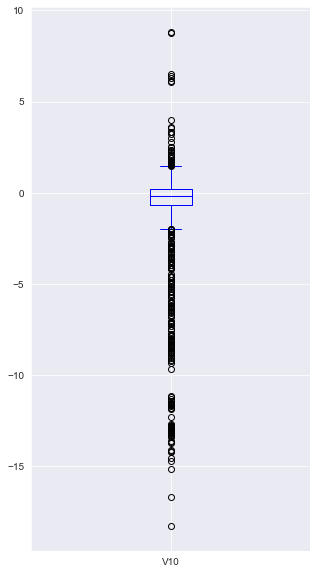

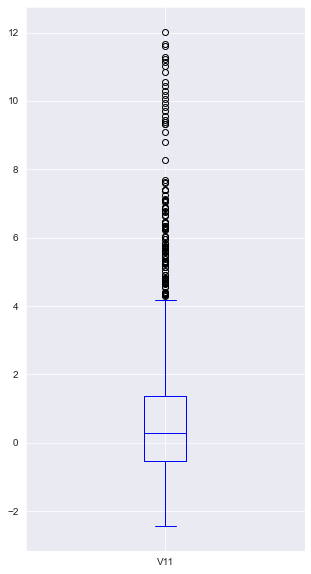

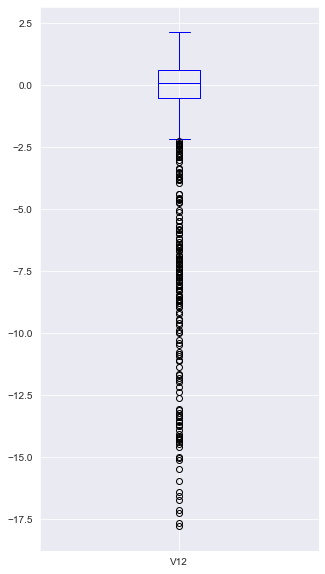

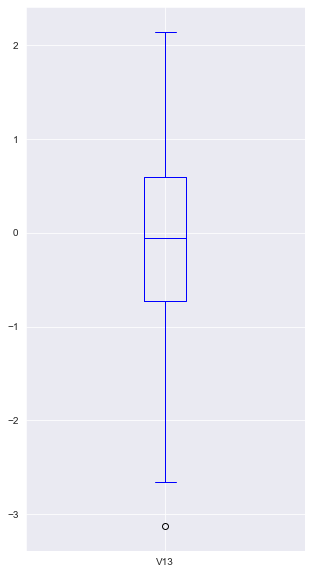

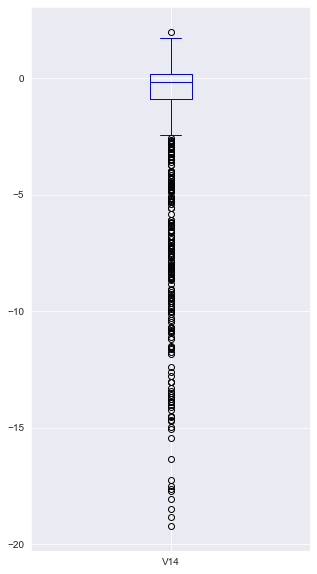

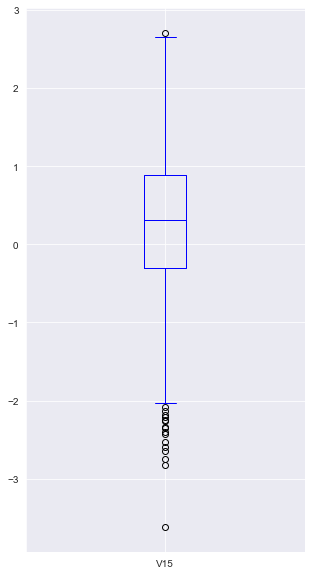

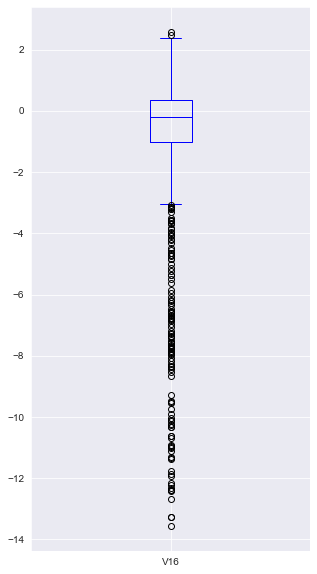

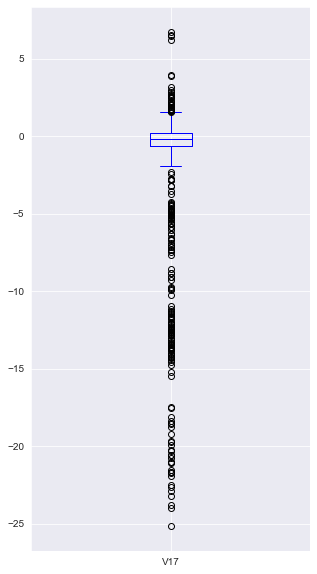

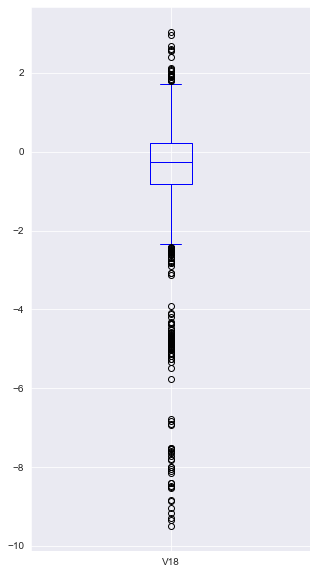

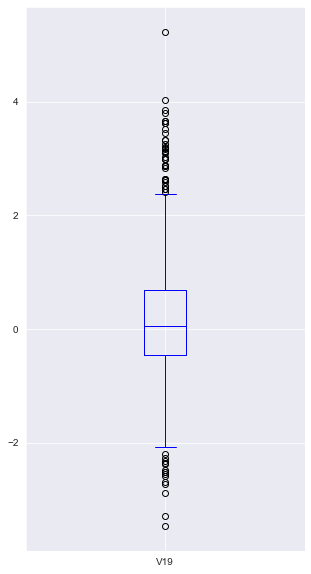

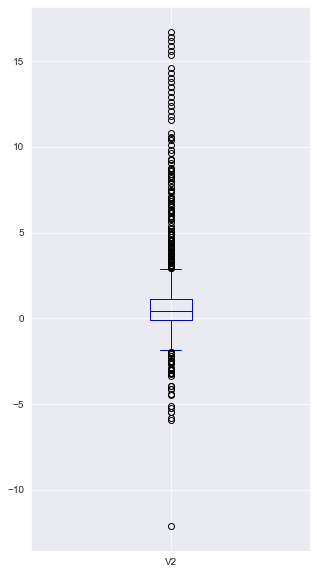

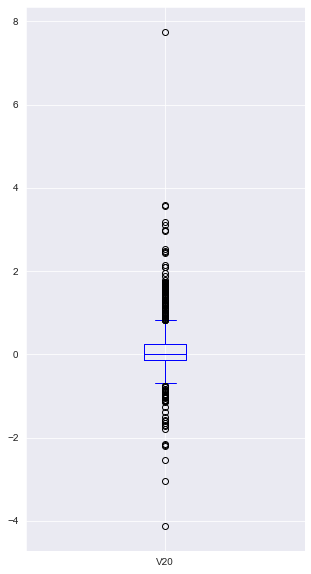

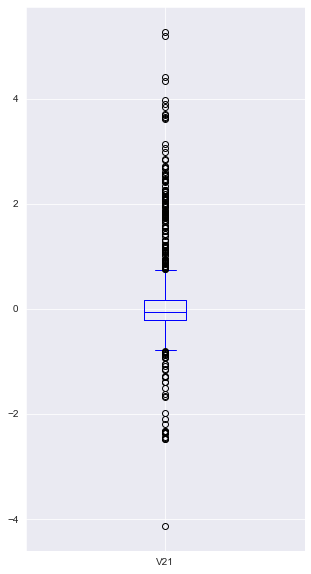

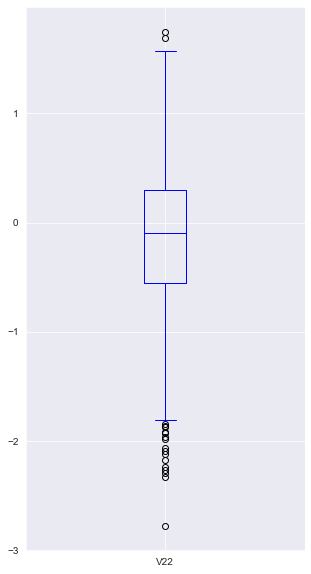

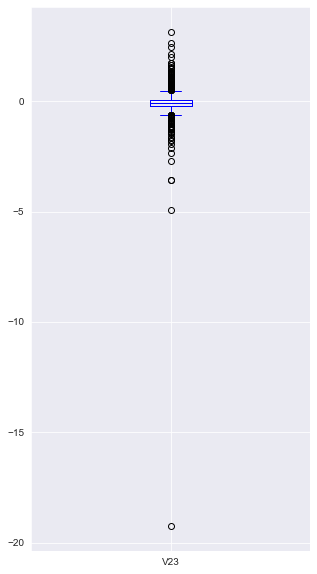

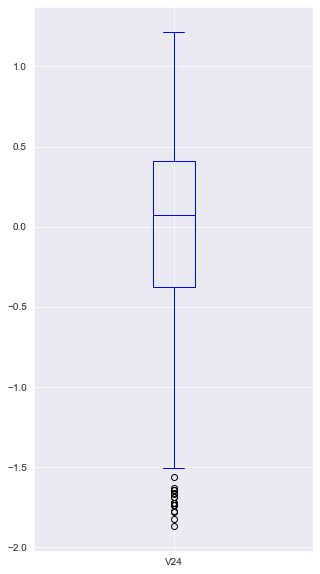

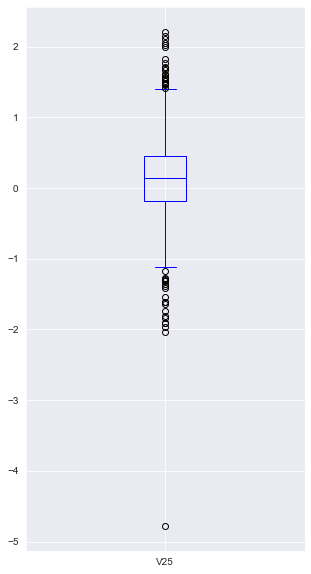

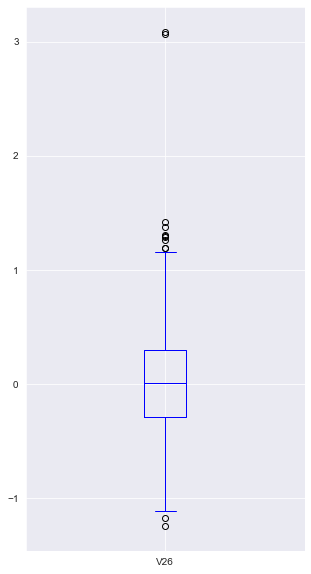

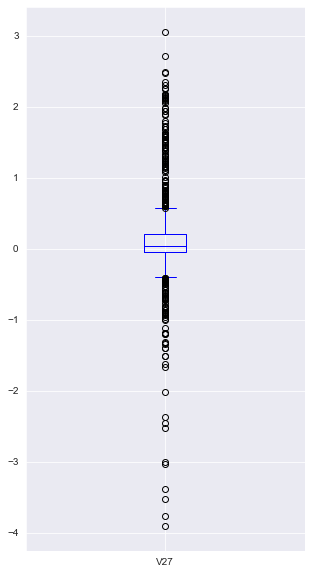

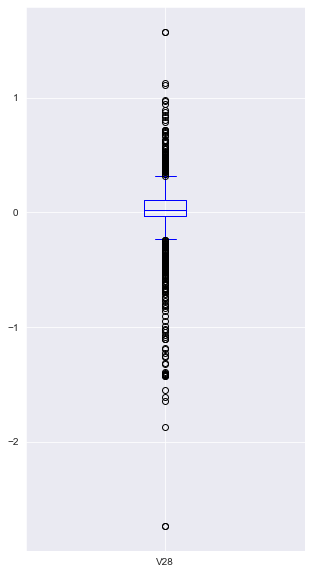

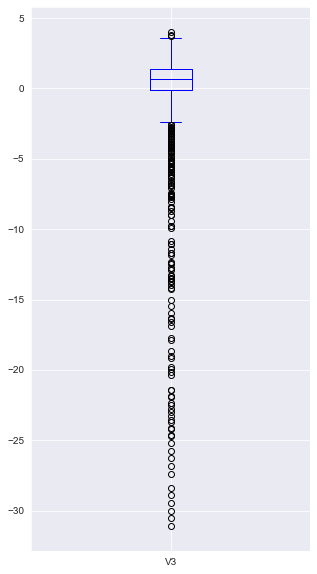

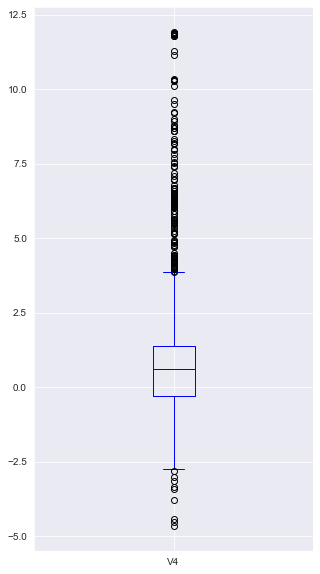

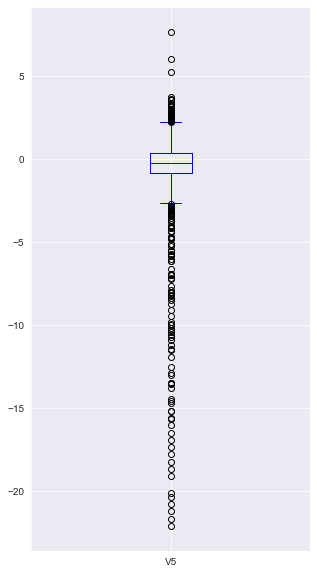

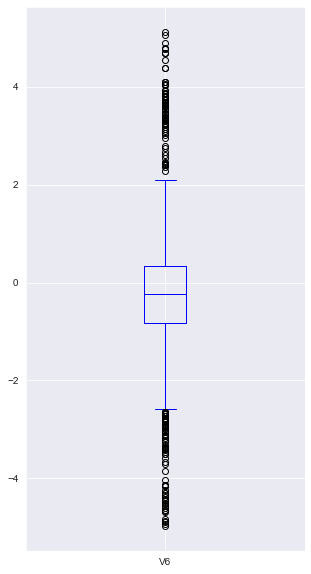

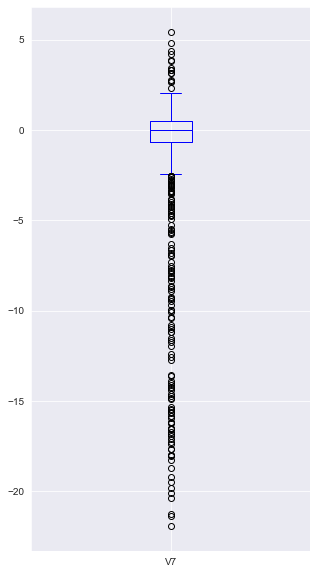

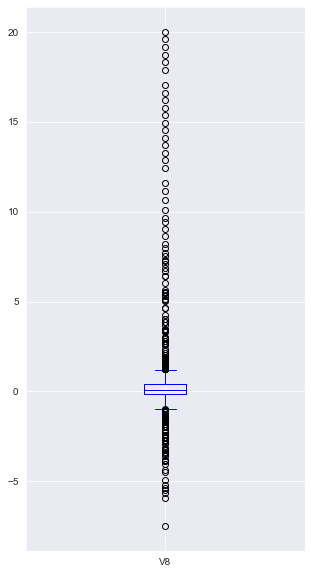

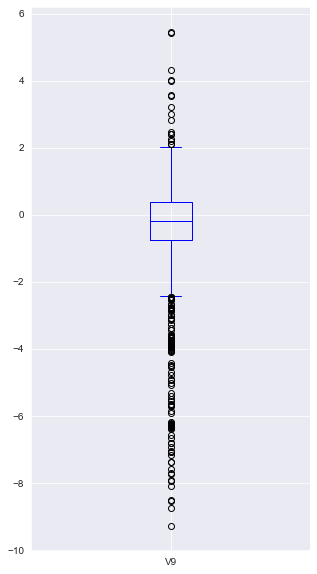

In [9]:
features = df.columns.difference(['Class'])

for c in features:
    plt.figure(figsize=(5, 10))
    ax = df.boxplot([c],color ='blue')
    plt.show()

There are outliers.

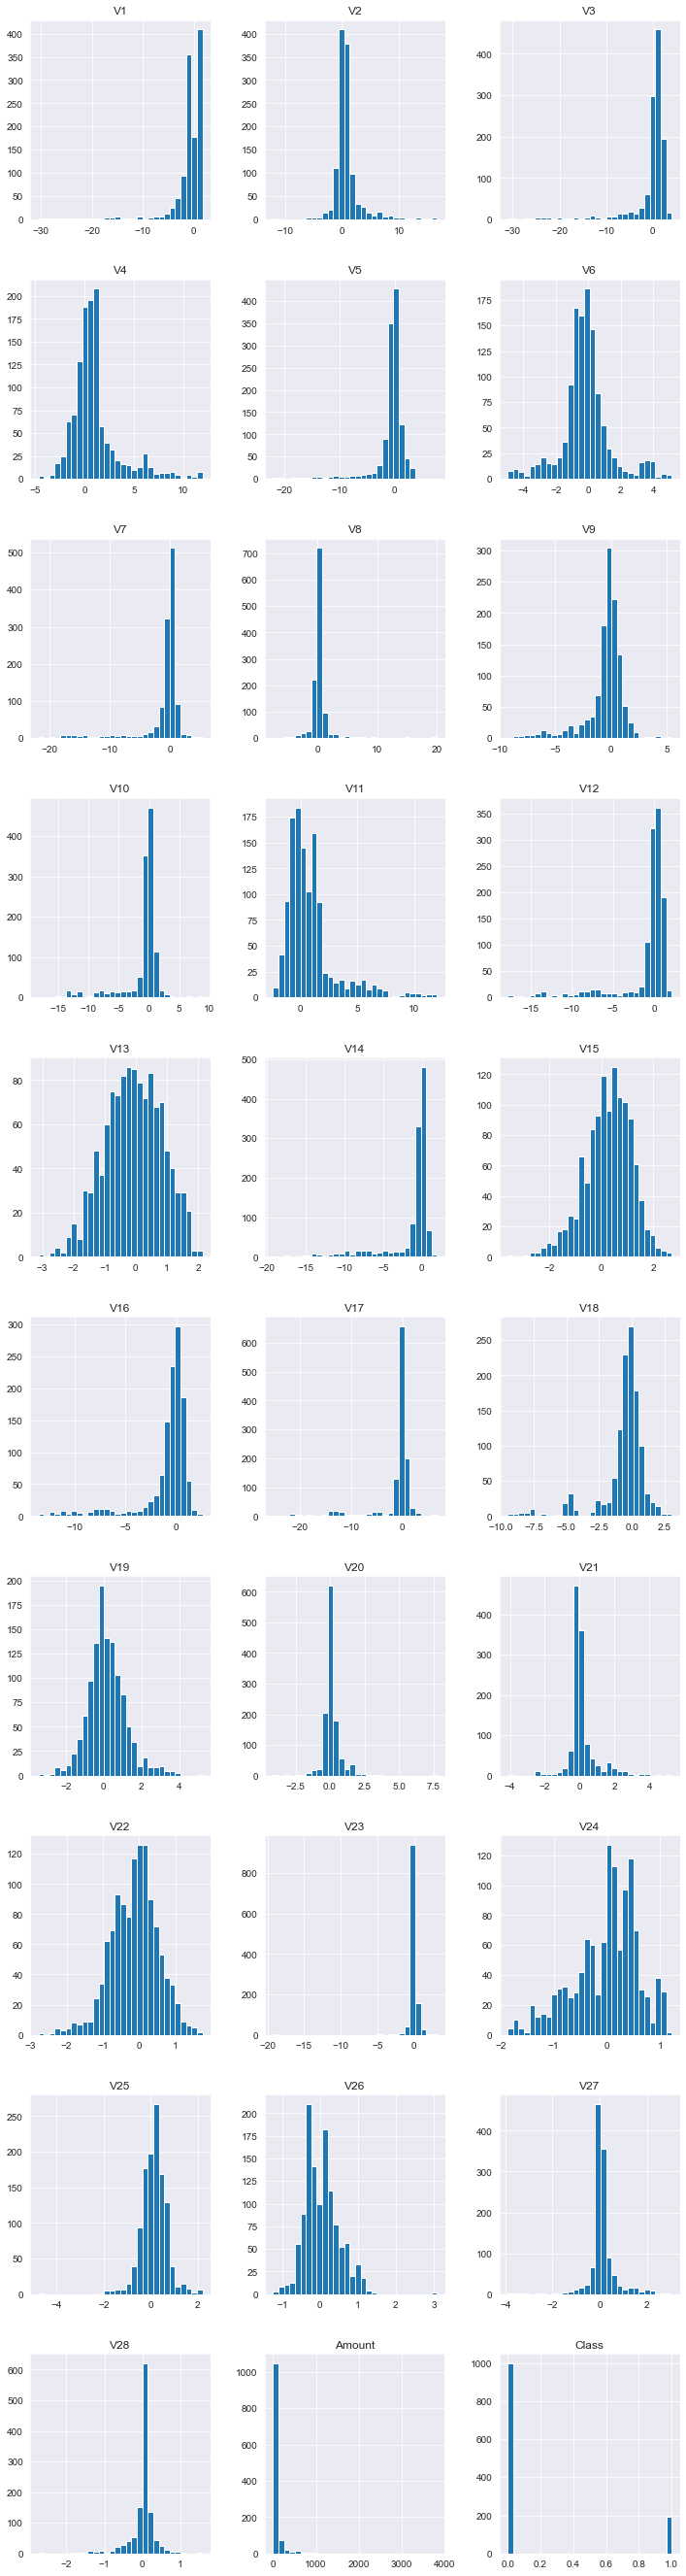

In [10]:

fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df.hist(column = df.columns[i], bins = 30, ax=axis)
        i = i+1
    

The numeric features are skewed, hence we need to apply scaling to the numeric features.

#### Bivariate Analysis

<Figure size 360x720 with 0 Axes>

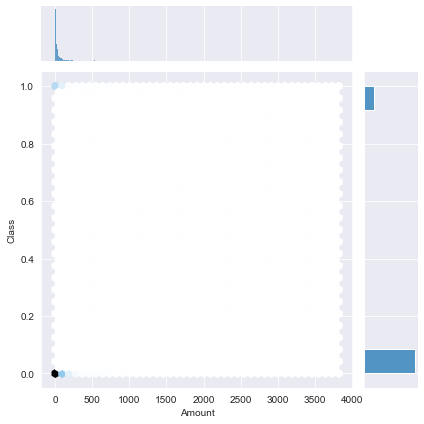

<Figure size 360x720 with 0 Axes>

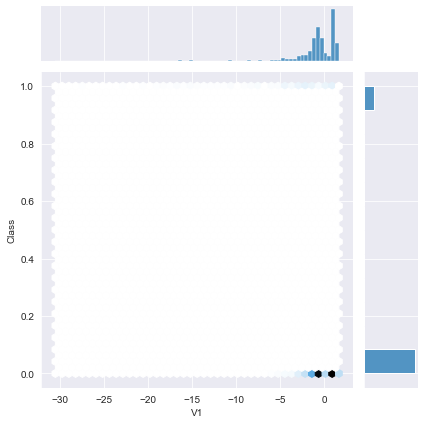

<Figure size 360x720 with 0 Axes>

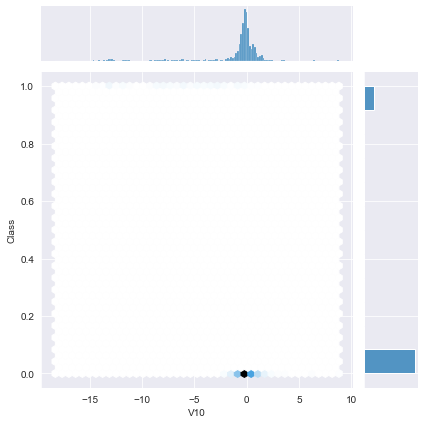

<Figure size 360x720 with 0 Axes>

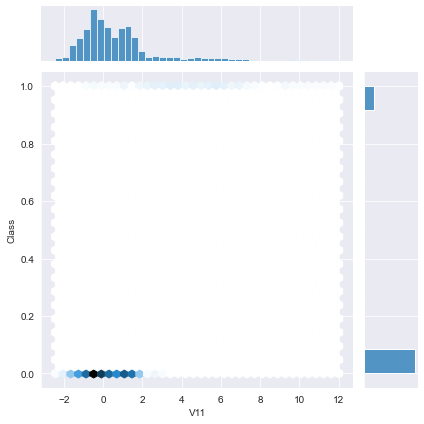

<Figure size 360x720 with 0 Axes>

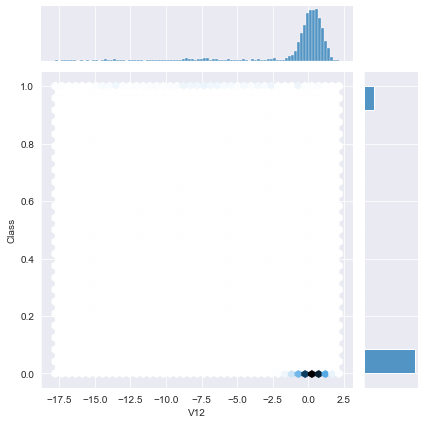

<Figure size 360x720 with 0 Axes>

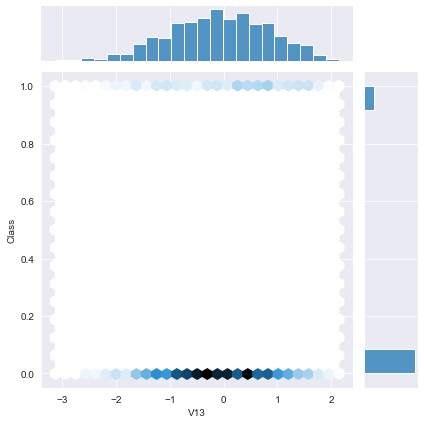

<Figure size 360x720 with 0 Axes>

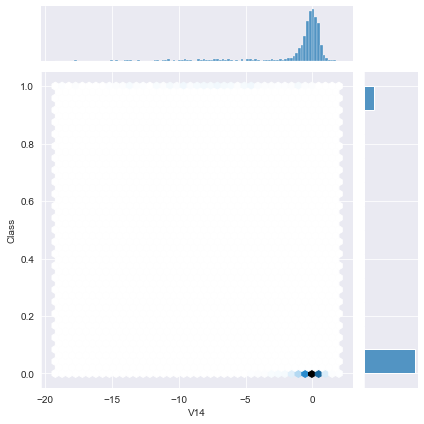

<Figure size 360x720 with 0 Axes>

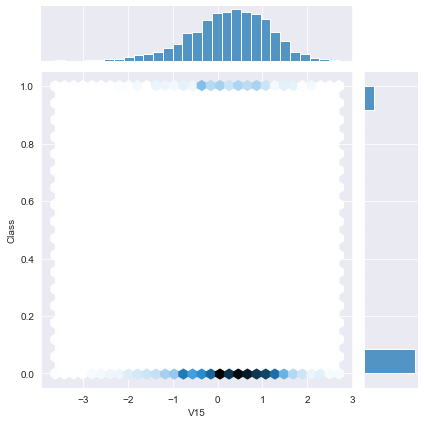

<Figure size 360x720 with 0 Axes>

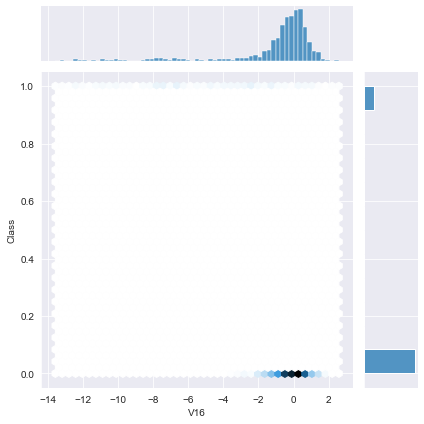

<Figure size 360x720 with 0 Axes>

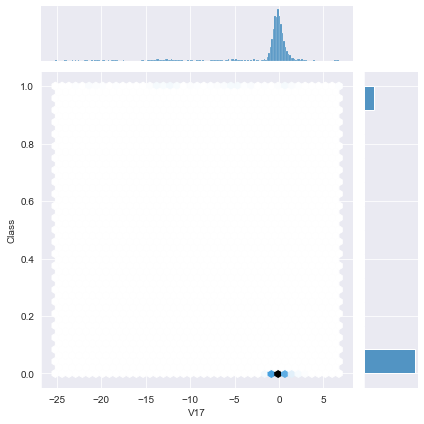

<Figure size 360x720 with 0 Axes>

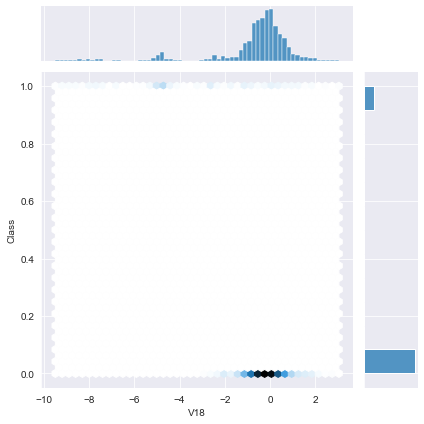

<Figure size 360x720 with 0 Axes>

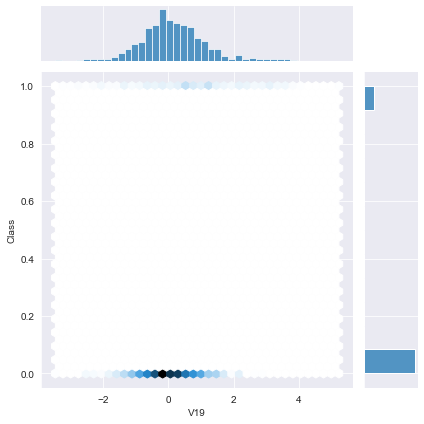

<Figure size 360x720 with 0 Axes>

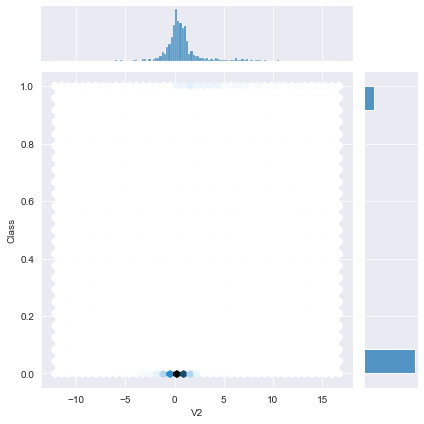

<Figure size 360x720 with 0 Axes>

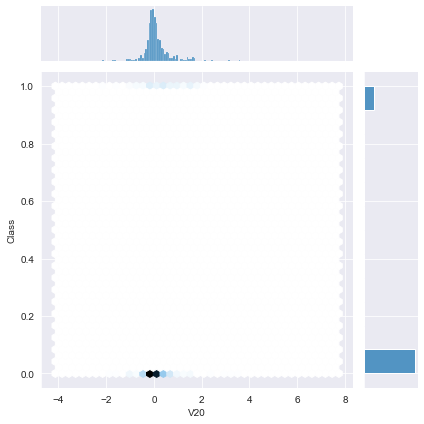

<Figure size 360x720 with 0 Axes>

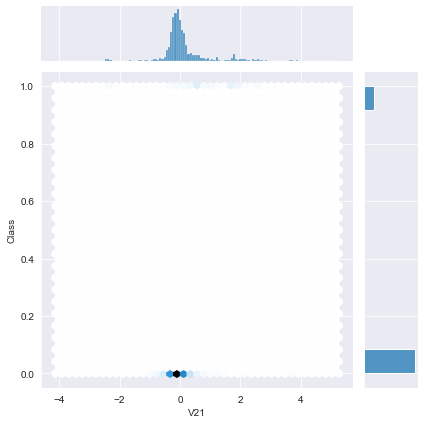

<Figure size 360x720 with 0 Axes>

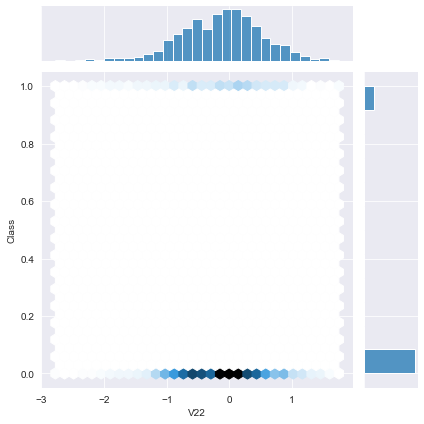

<Figure size 360x720 with 0 Axes>

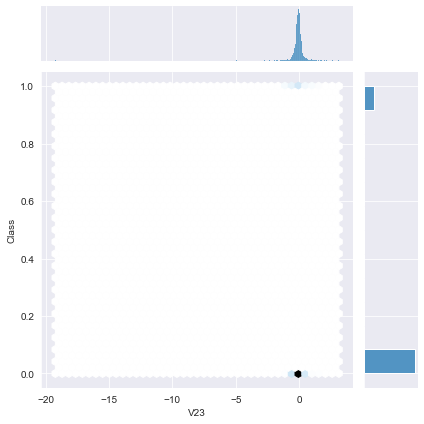

<Figure size 360x720 with 0 Axes>

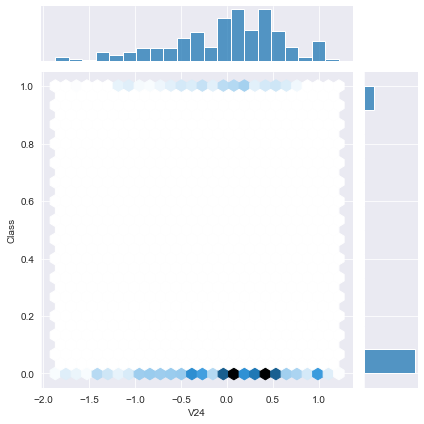

<Figure size 360x720 with 0 Axes>

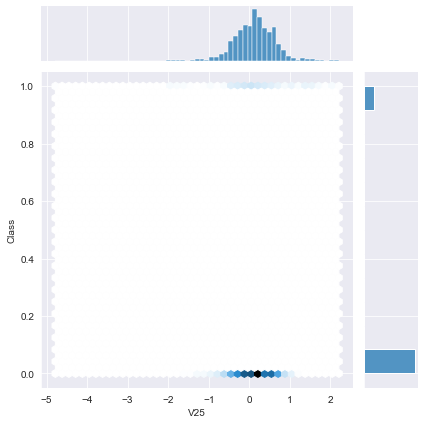

<Figure size 360x720 with 0 Axes>

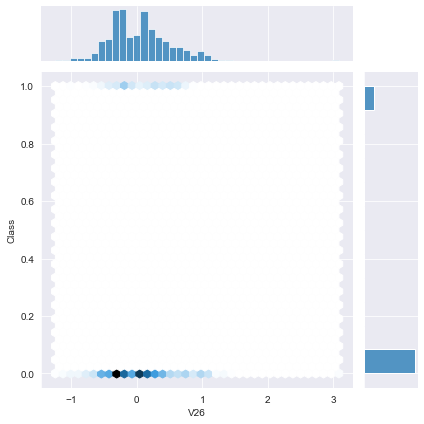

<Figure size 360x720 with 0 Axes>

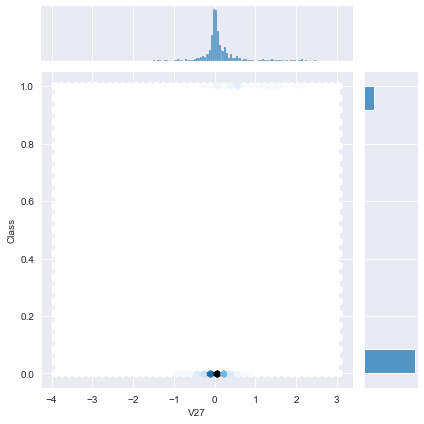

<Figure size 360x720 with 0 Axes>

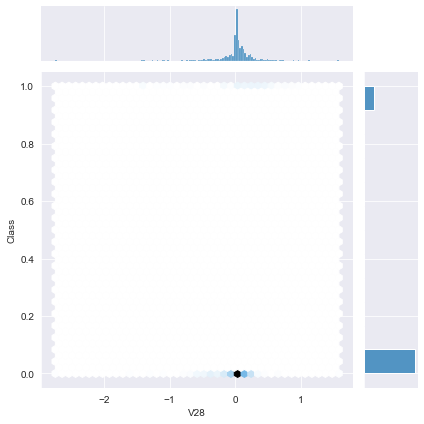

<Figure size 360x720 with 0 Axes>

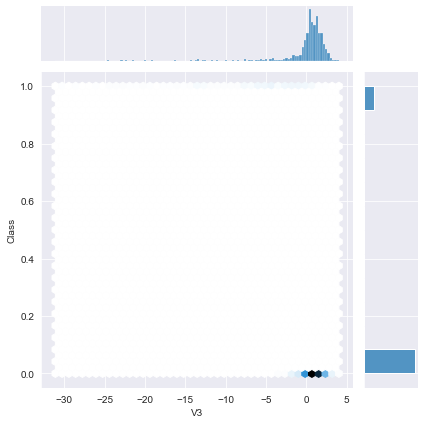

<Figure size 360x720 with 0 Axes>

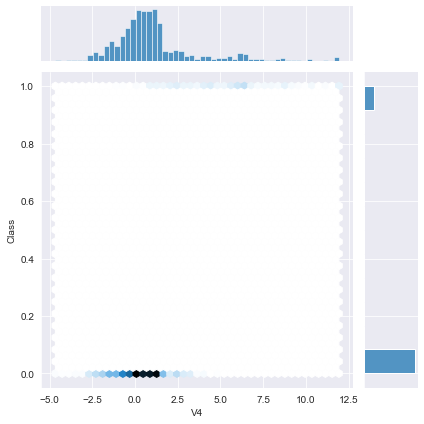

<Figure size 360x720 with 0 Axes>

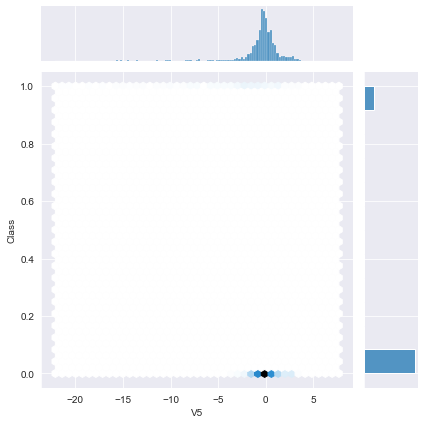

<Figure size 360x720 with 0 Axes>

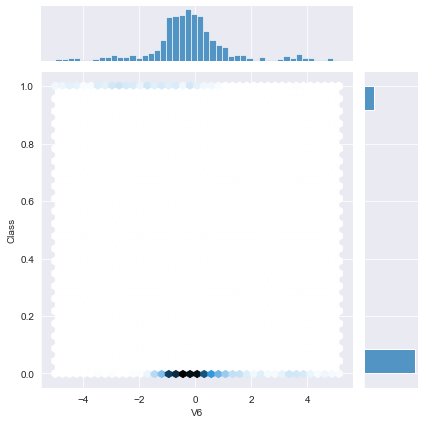

<Figure size 360x720 with 0 Axes>

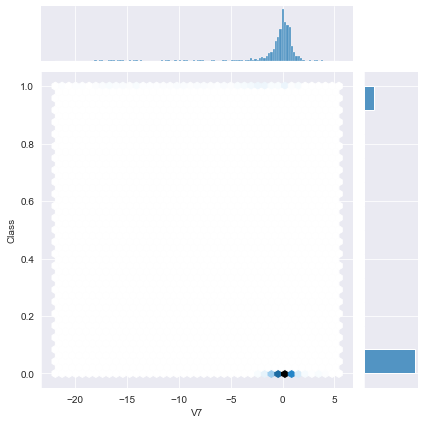

<Figure size 360x720 with 0 Axes>

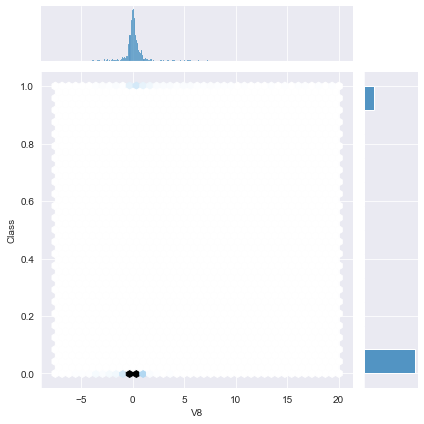

<Figure size 360x720 with 0 Axes>

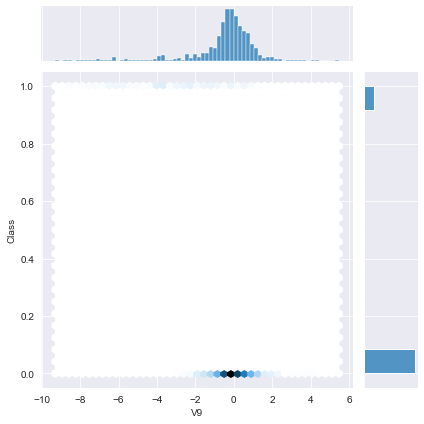

In [11]:
#for checking two variables distributions at a time in Python, we can use the joint plot function.
for c in features:
    plt.figure(figsize=(5, 10))
    sns.jointplot(y='Class',x=c,data=df,kind='hex')
    plt.show()


<Figure size 216x360 with 0 Axes>

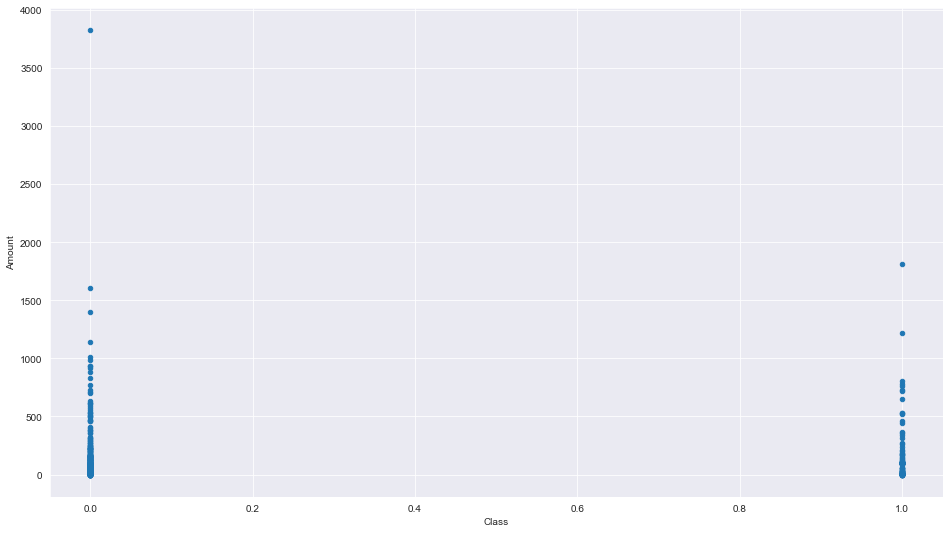

<Figure size 216x360 with 0 Axes>

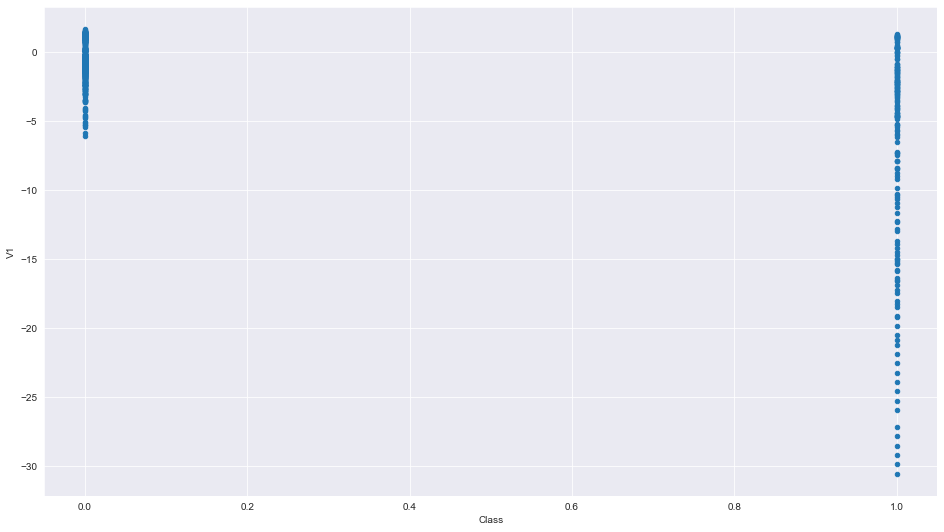

<Figure size 216x360 with 0 Axes>

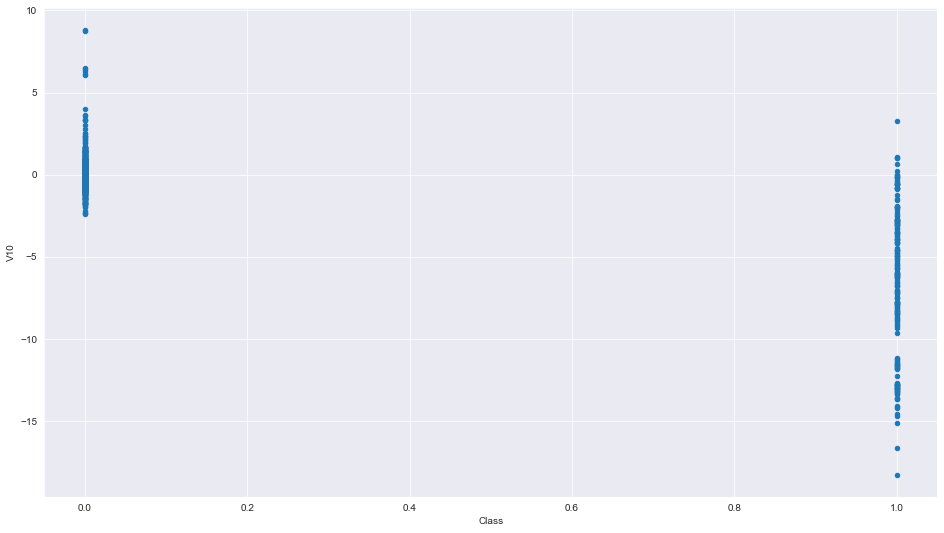

<Figure size 216x360 with 0 Axes>

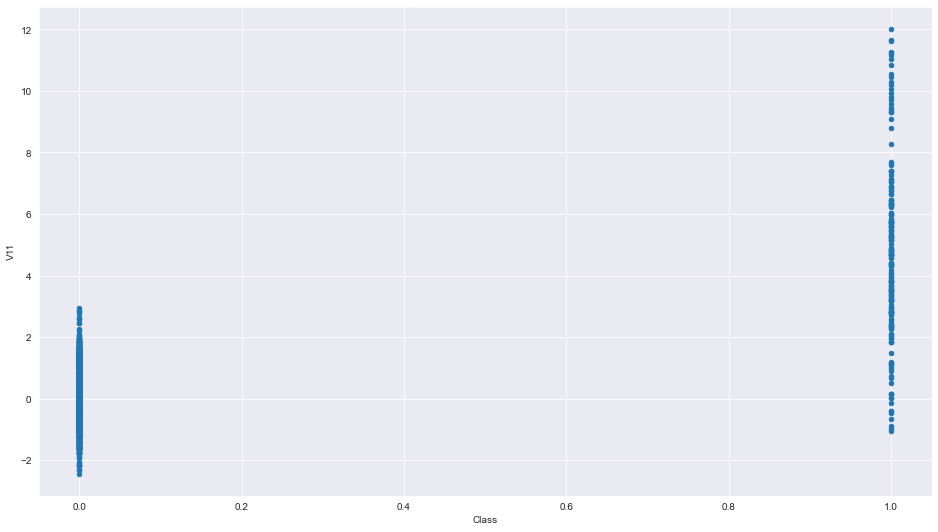

<Figure size 216x360 with 0 Axes>

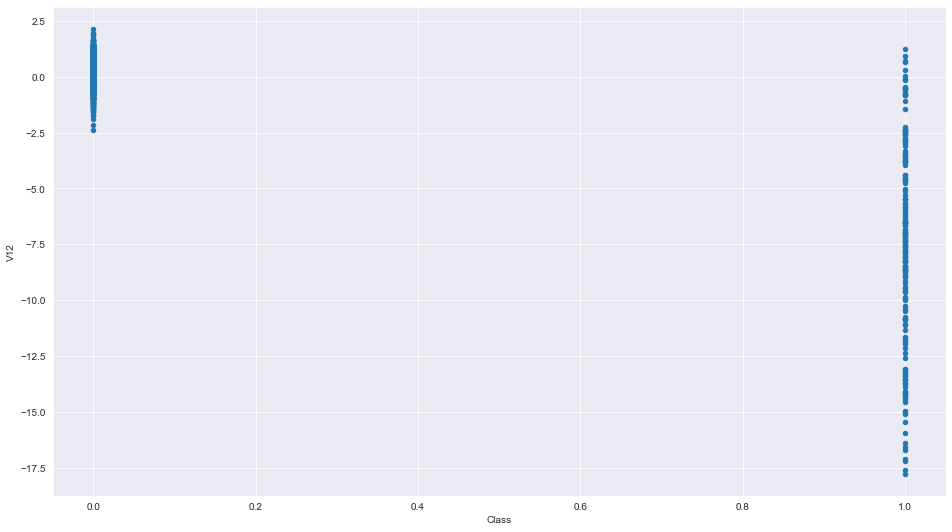

<Figure size 216x360 with 0 Axes>

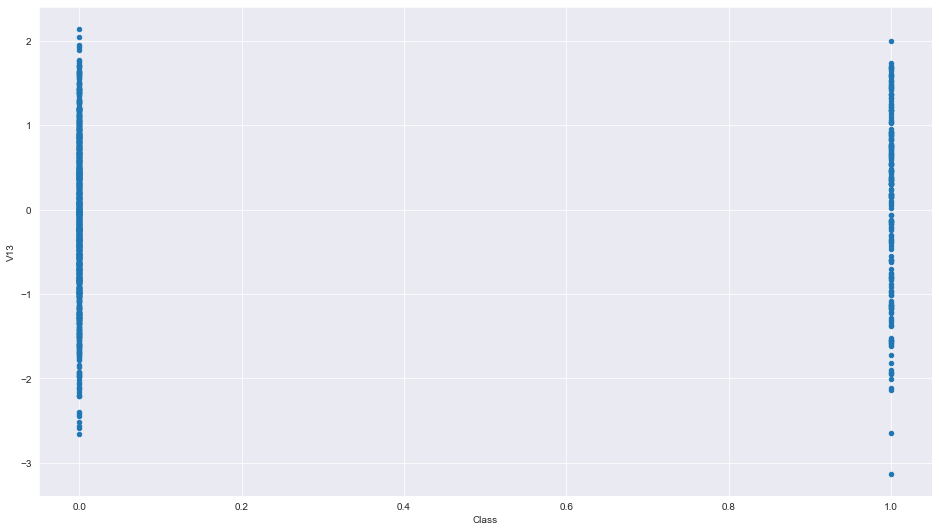

<Figure size 216x360 with 0 Axes>

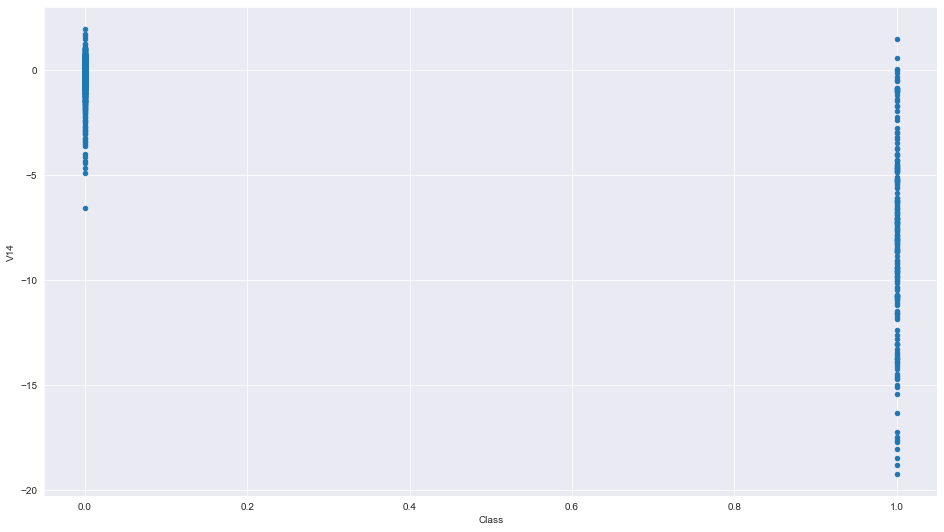

<Figure size 216x360 with 0 Axes>

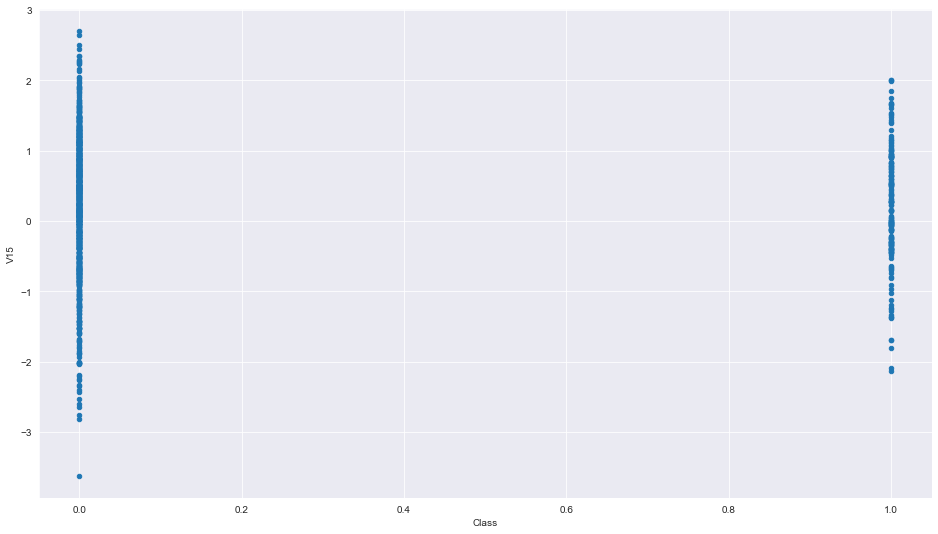

<Figure size 216x360 with 0 Axes>

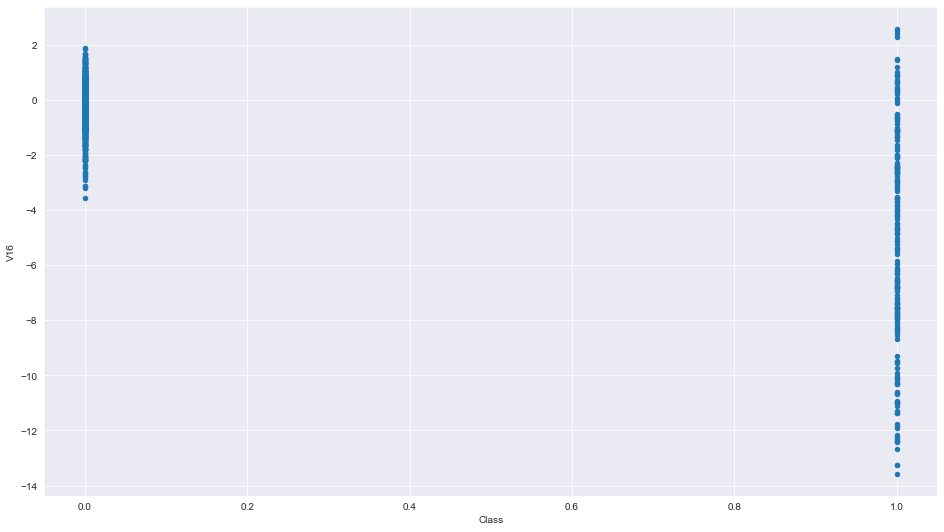

<Figure size 216x360 with 0 Axes>

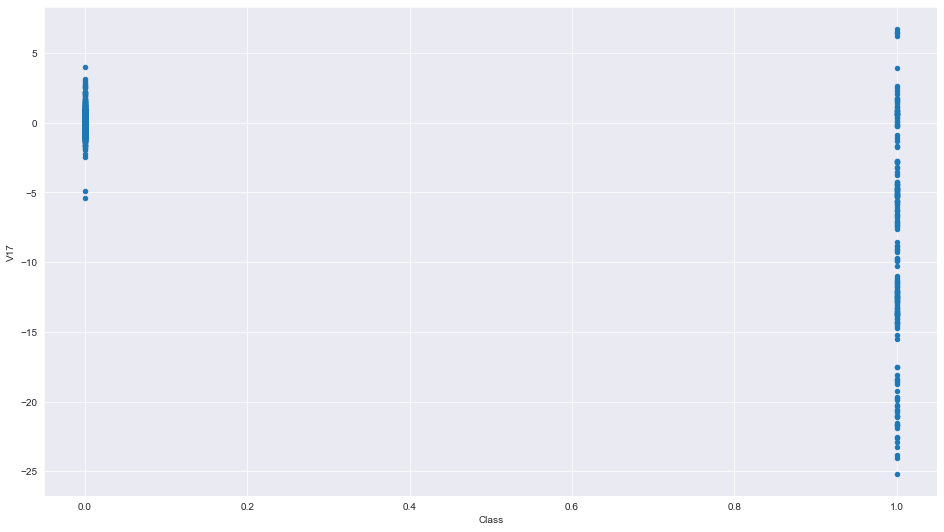

<Figure size 216x360 with 0 Axes>

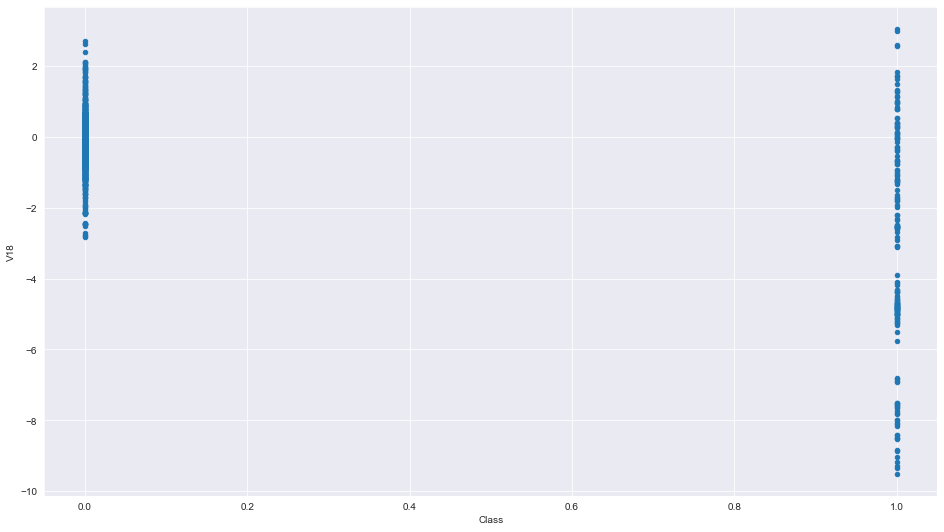

<Figure size 216x360 with 0 Axes>

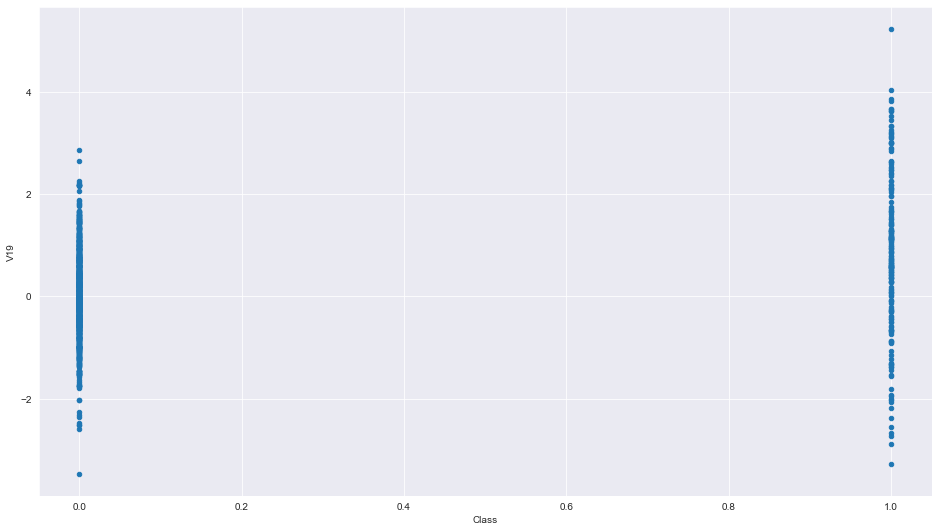

<Figure size 216x360 with 0 Axes>

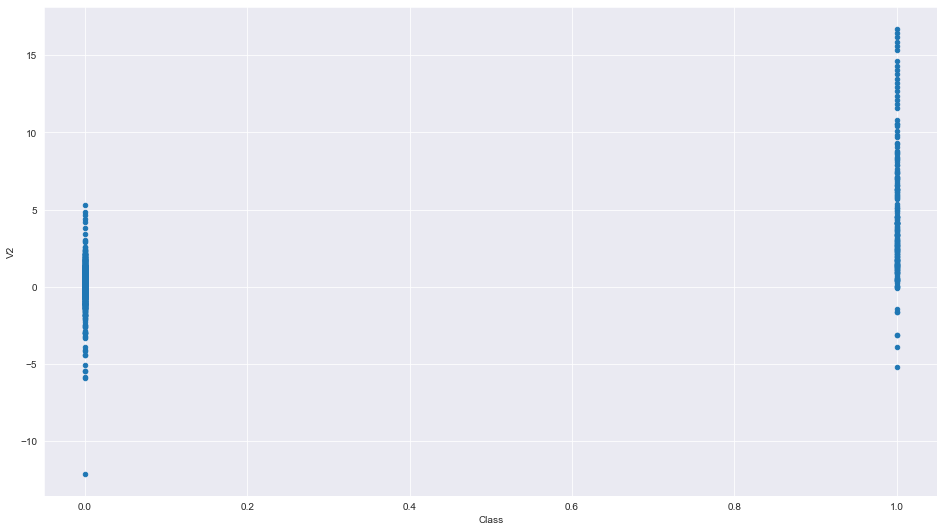

<Figure size 216x360 with 0 Axes>

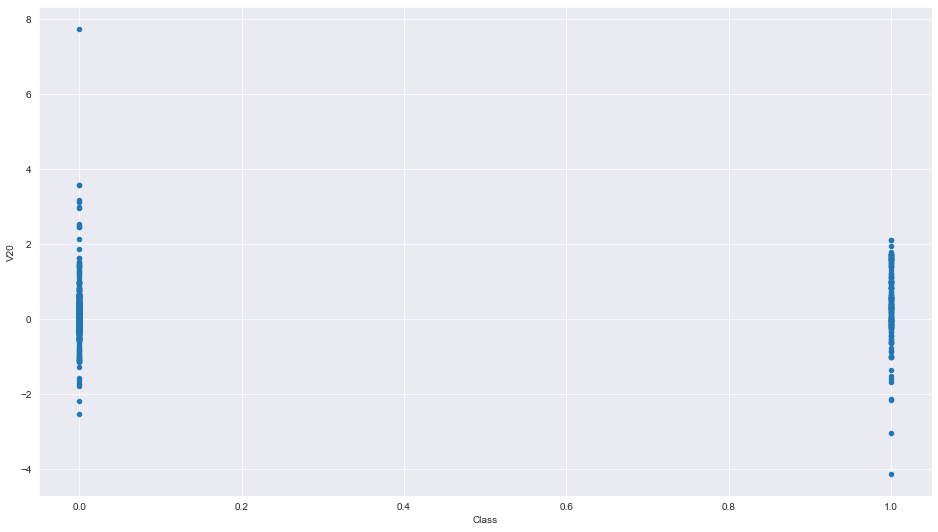

<Figure size 216x360 with 0 Axes>

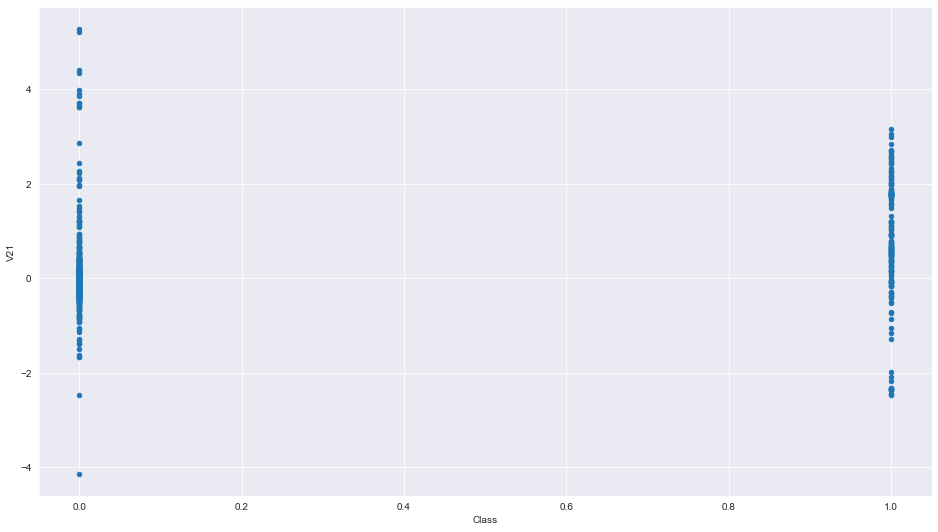

<Figure size 216x360 with 0 Axes>

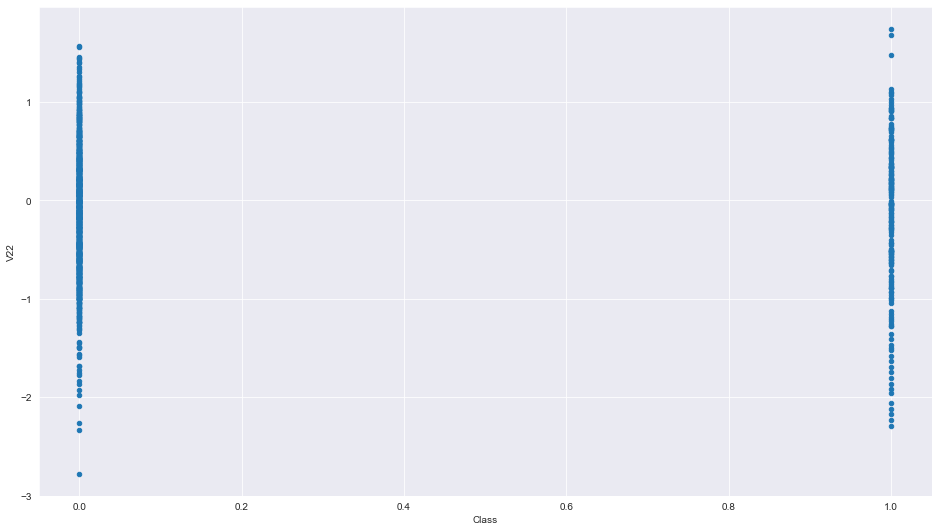

<Figure size 216x360 with 0 Axes>

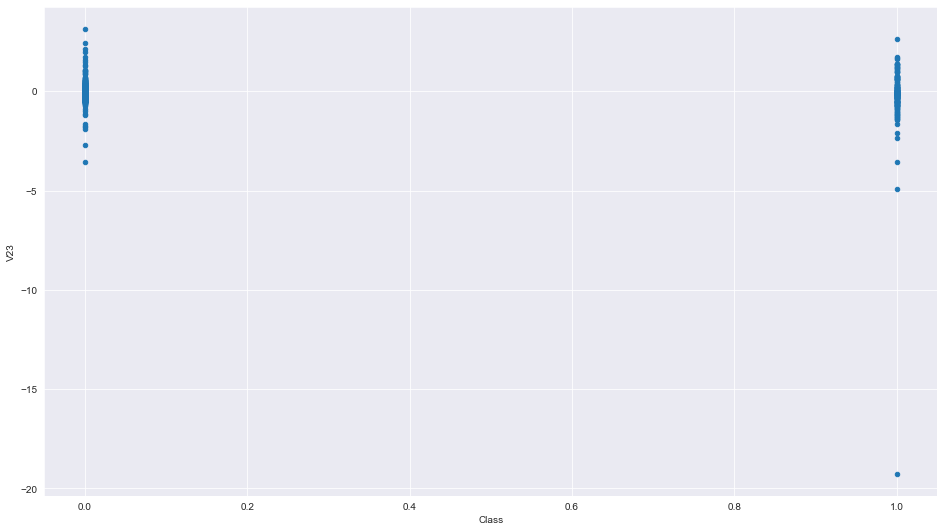

<Figure size 216x360 with 0 Axes>

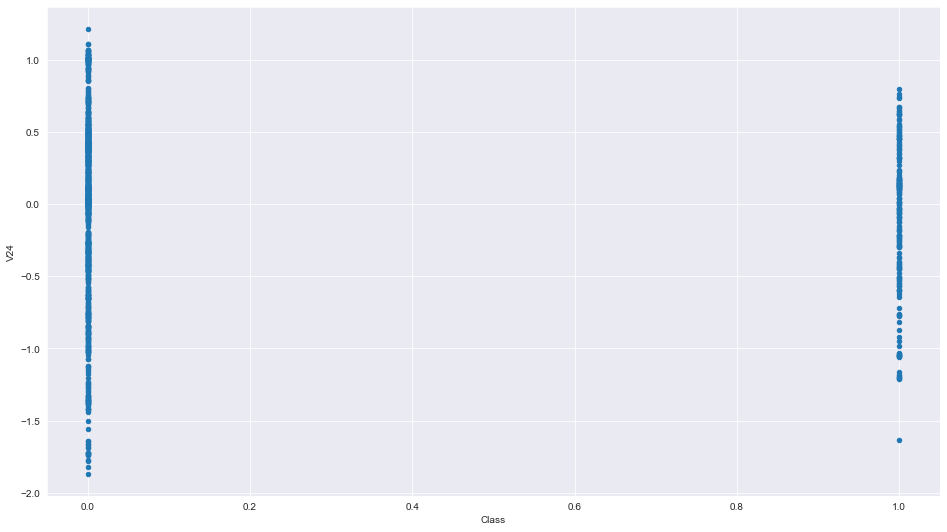

<Figure size 216x360 with 0 Axes>

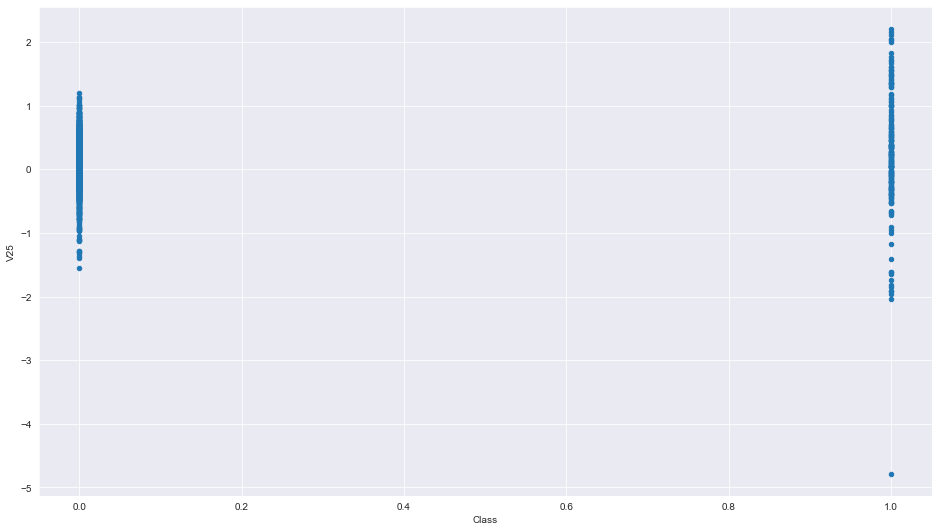

<Figure size 216x360 with 0 Axes>

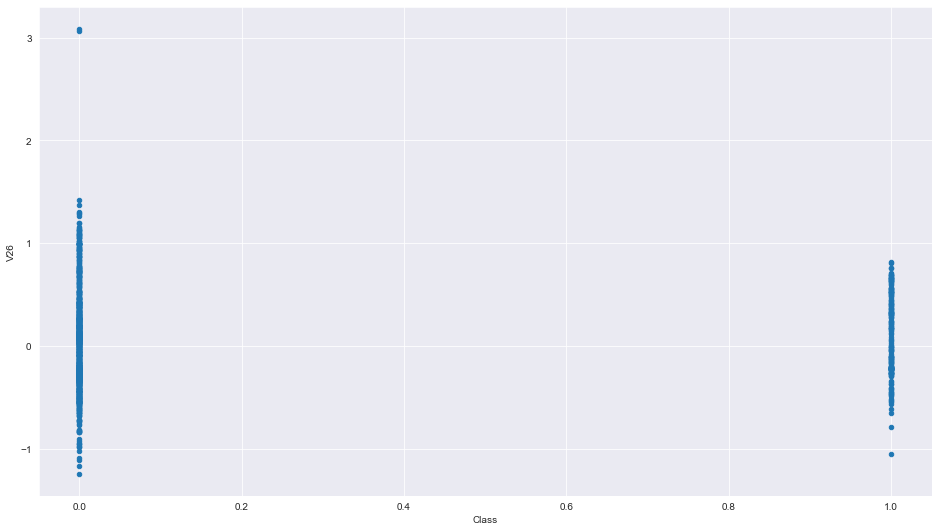

<Figure size 216x360 with 0 Axes>

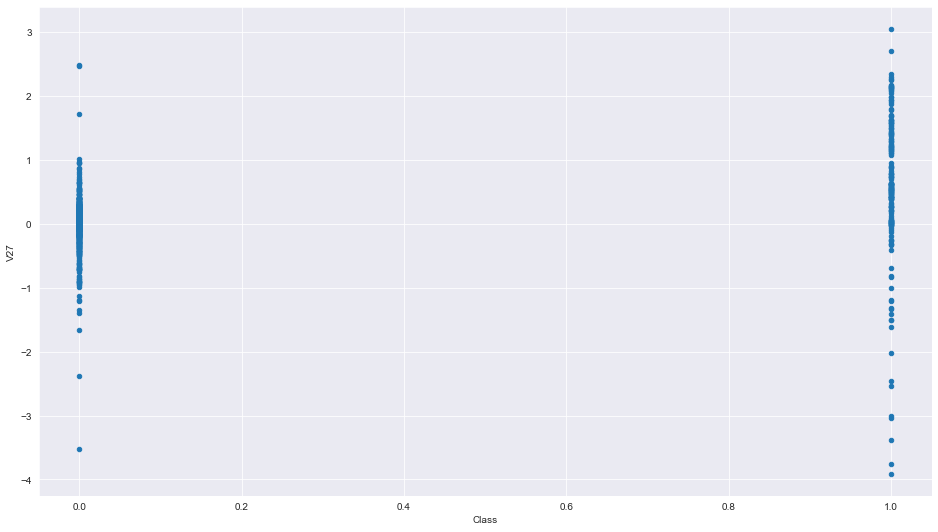

<Figure size 216x360 with 0 Axes>

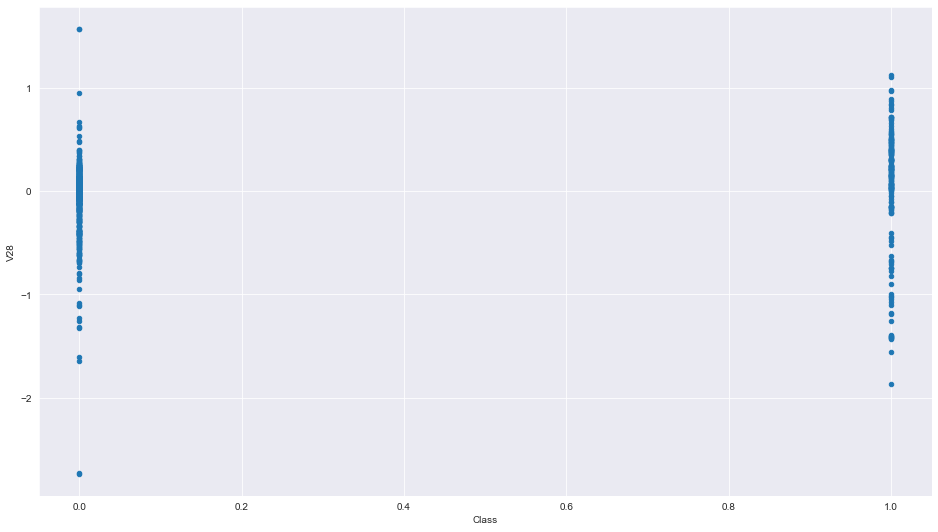

<Figure size 216x360 with 0 Axes>

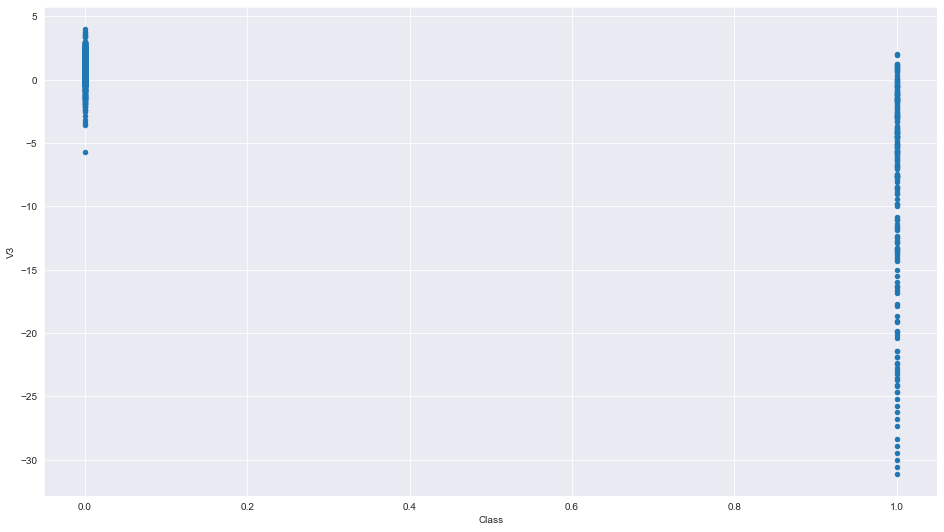

<Figure size 216x360 with 0 Axes>

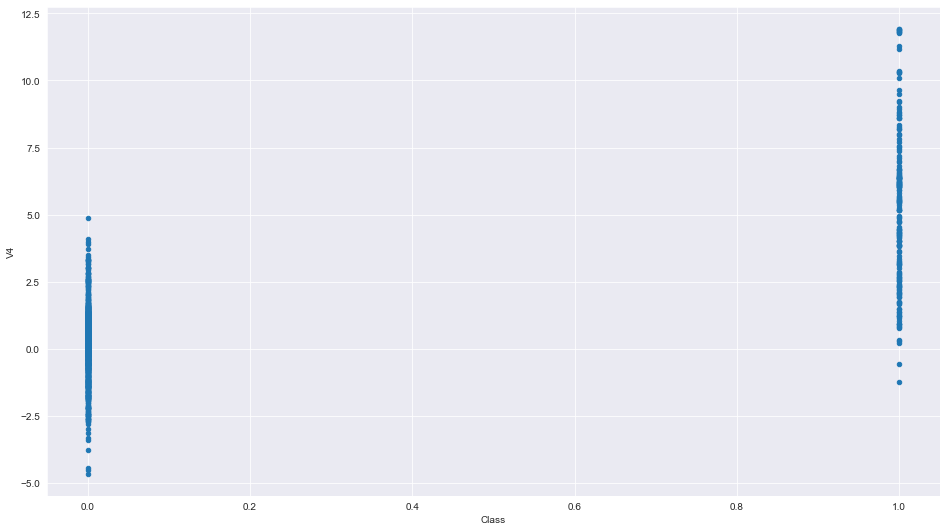

<Figure size 216x360 with 0 Axes>

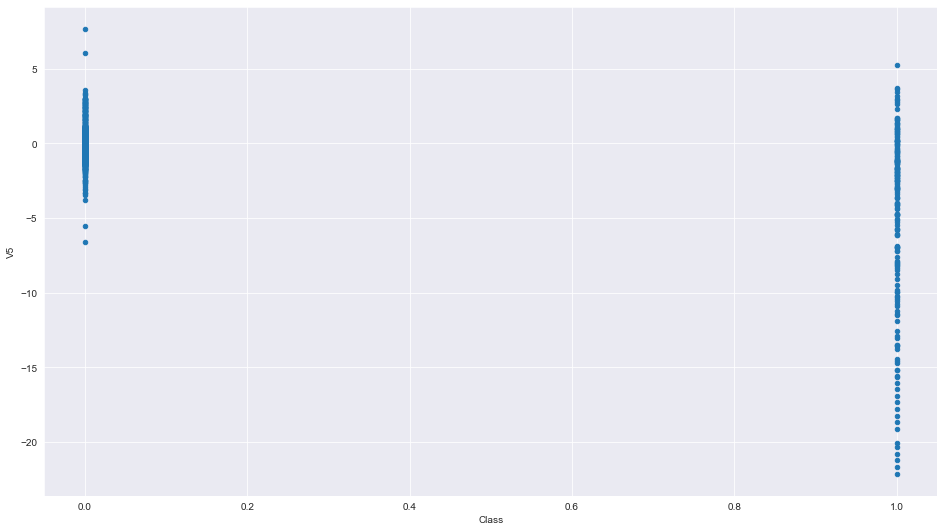

<Figure size 216x360 with 0 Axes>

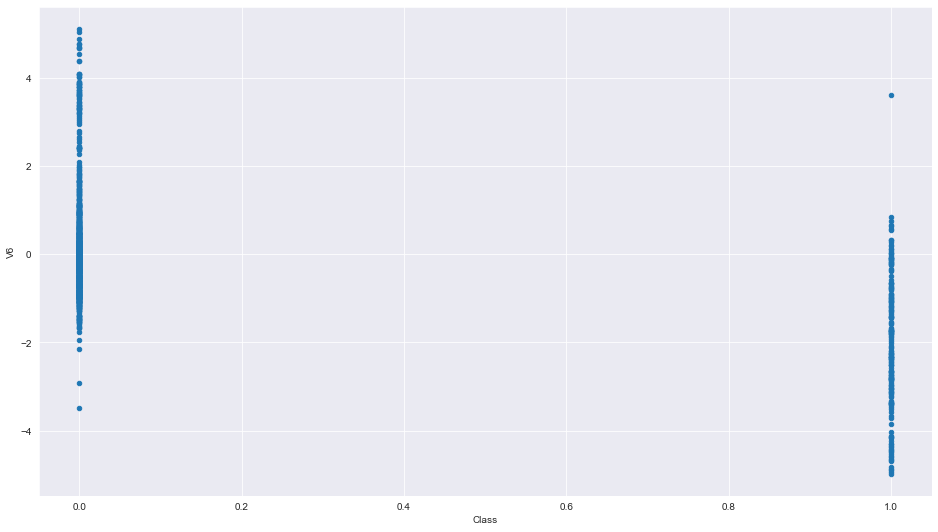

<Figure size 216x360 with 0 Axes>

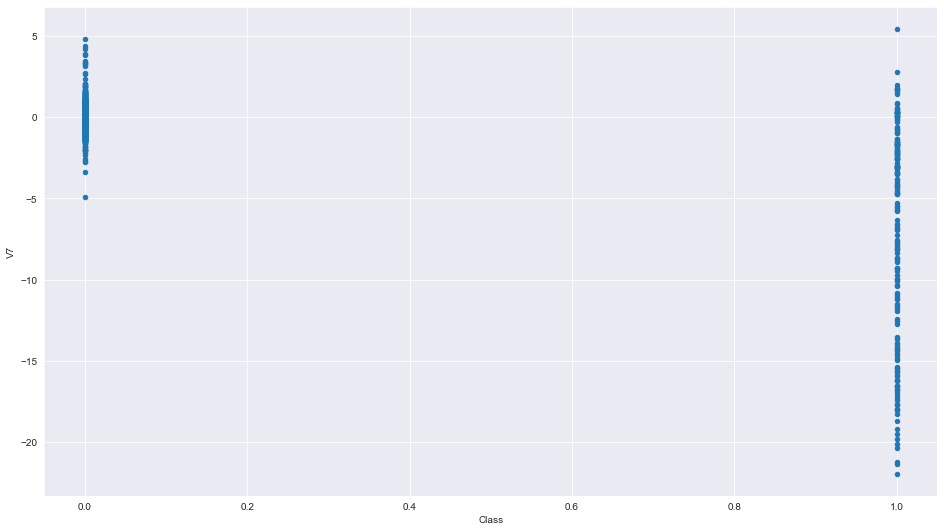

<Figure size 216x360 with 0 Axes>

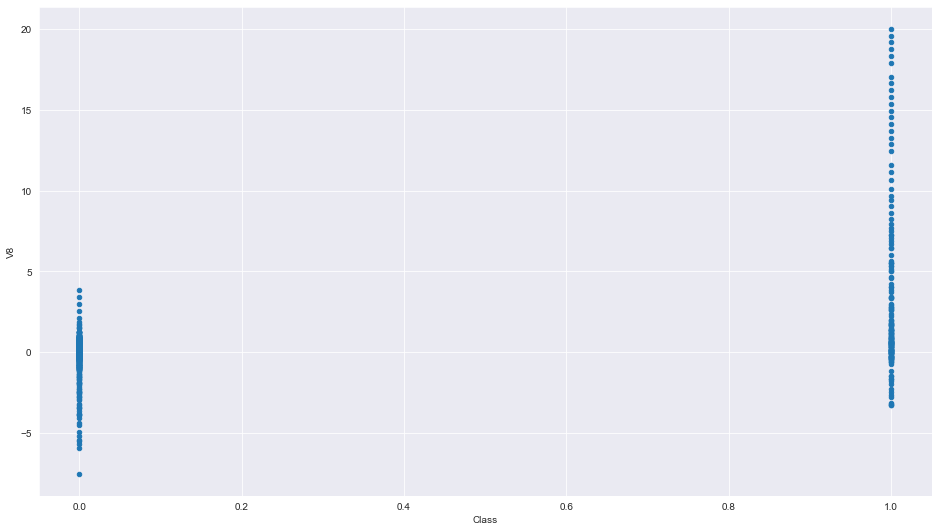

<Figure size 216x360 with 0 Axes>

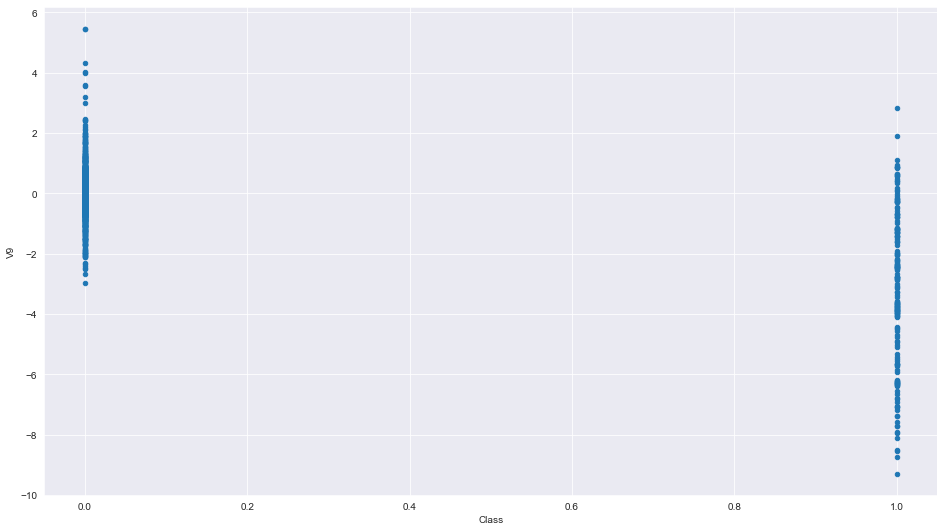

In [12]:
#Scatter plots are useful to show individual values plot on a two dimensional cartesian X & Y plane..
for c in features:
    plt.figure(figsize=(3, 5))
    df.plot.scatter(x='Class', y=c,colormap='viridis')
    plt.show()


#### Multivariate analysis

In [13]:
df.corr()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,1.000000,-0.820375,0.874481,-0.599671,0.852142,0.495271,0.860773,-0.779344,0.598867,0.686396,...,-0.283913,0.160701,0.182482,-0.010745,-0.154776,0.005546,-0.309195,0.120334,-0.104289,-0.575247
V2,-0.820375,1.000000,-0.870836,0.670435,-0.783531,-0.556859,-0.807687,0.741477,-0.642396,-0.708304,...,0.319286,-0.204317,-0.132276,-0.034675,0.198518,0.010092,0.377574,0.034667,-0.208151,0.631650
V3,0.874481,-0.870836,1.000000,-0.754549,0.853307,0.557123,0.924495,-0.783934,0.731176,0.833005,...,-0.275849,0.187225,0.159555,0.064669,-0.249427,-0.034606,-0.433075,0.009926,-0.067227,-0.711600
V4,-0.599671,0.670435,-0.754549,1.000000,-0.596521,-0.474408,-0.748905,0.489224,-0.744023,-0.792558,...,0.239654,0.034856,-0.107167,-0.067729,0.083034,0.099570,0.408336,0.012027,0.062118,0.746038
V5,0.852142,-0.783531,0.853307,-0.596521,1.000000,0.526069,0.859186,-0.815868,0.620657,0.707101,...,-0.337836,0.131236,0.126502,-0.037540,-0.205503,-0.029248,-0.285112,0.024744,-0.159069,-0.554263
V6,0.495271,-0.556859,0.557123,-0.474408,0.526069,1.000000,0.540145,-0.459042,0.469858,0.541934,...,-0.206559,0.122556,0.115472,0.012736,-0.117631,-0.029033,-0.285327,-0.096623,0.182097,-0.528143
V7,0.860773,-0.807687,0.924495,-0.748905,0.859186,0.540145,1.000000,-0.741496,0.757345,0.868138,...,-0.318850,0.085220,0.221650,0.012881,-0.146631,-0.051850,-0.392769,0.023243,0.041712,-0.685542
V8,-0.779344,0.741477,-0.783934,0.489224,-0.815868,-0.459042,-0.741496,1.000000,-0.516666,-0.581053,...,0.322545,-0.217361,-0.155727,0.040440,0.311423,-0.027750,0.332808,0.194118,0.014855,0.466548
V9,0.598867,-0.642396,0.731176,-0.744023,0.620657,0.469858,0.757345,-0.516666,1.000000,0.836276,...,-0.277425,-0.001473,0.085359,0.024188,-0.058865,-0.070777,-0.316113,-0.053184,-0.032934,-0.664403
V10,0.686396,-0.708304,0.833005,-0.792558,0.707101,0.541934,0.868138,-0.581053,0.836276,1.000000,...,-0.338498,-0.007656,0.121730,0.060059,-0.071124,-0.091224,-0.377094,-0.030313,-0.055327,-0.777057


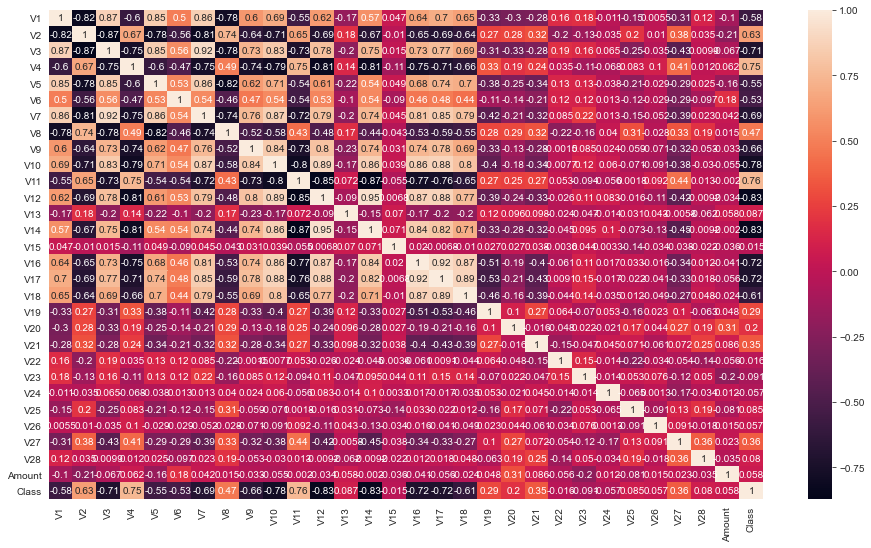

In [14]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(df.corr(), annot=True)
plt.show()

#### Outliers removal

In [15]:
df.shape

(1191, 30)

In [16]:
from scipy import stats
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df[filtered_entries]
new_df.shape

(1028, 30)

In [17]:
#division of data
zero_count = len(new_df[new_df['Class']==0])
one_count = len(new_df) - zero_count

print(" Total Zeros:",zero_count,"\n","Total Ones:",one_count)

 Total Zeros: 933 
 Total Ones: 95


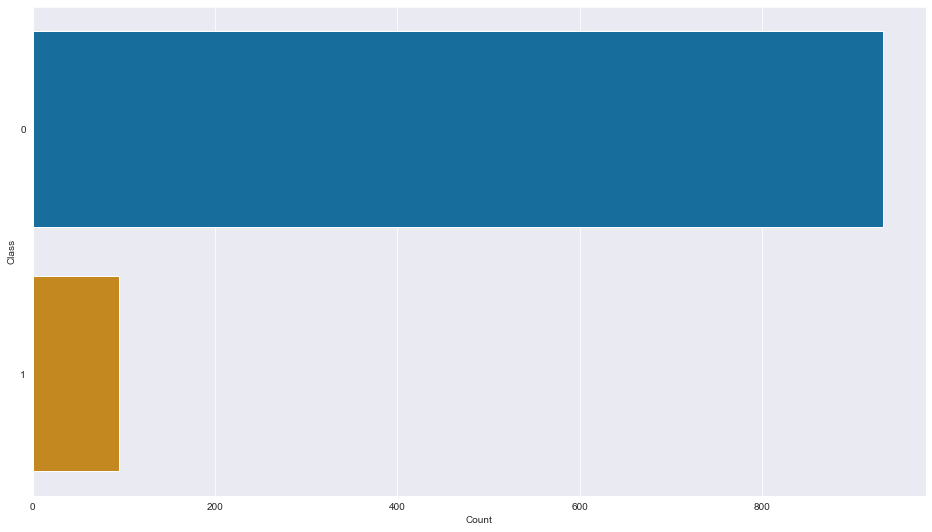

In [18]:
sns.set_style('darkgrid')
sns.countplot(y='Class',data=new_df,palette='colorblind')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show() 

After outliers removal, the dataset is even more unbalanced.

#### Scale the data

In [19]:
df=new_df.copy()
df.shape

(1028, 30)

In [20]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df_mm = pd.DataFrame(scaler.fit_transform(df[features]), columns = features)
df_mm 

,Amount,V1,V10,V11,V12,V13,V14,V15,V16,V17,...,V26,V27,V28,V3,V4,V5,V6,V7,V8,V9
0,0.236591,0.763775,0.685804,0.187483,0.794842,0.346969,0.833130,0.759403,0.710300,0.693508,...,0.402913,0.544801,0.499528,0.917735,0.499459,0.504202,0.566839,0.798925,0.430838,0.674600
1,0.004254,0.961720,0.664992,0.402683,0.919501,0.655447,0.845336,0.597263,0.798980,0.678361,...,0.523240,0.497508,0.517561,0.786114,0.422500,0.528855,0.501962,0.773295,0.429821,0.603863
2,0.598767,0.763888,0.695239,0.304423,0.845496,0.702995,0.843719,0.930320,0.480640,0.735835,...,0.422019,0.482123,0.480021,0.875351,0.416842,0.493998,0.726201,0.843347,0.441987,0.460014
3,0.195288,0.794304,0.674037,0.219809,0.853802,0.659336,0.834825,0.350539,0.654373,0.651647,...,0.390379,0.521299,0.541118,0.876449,0.313977,0.524503,0.660306,0.798765,0.451697,0.474594
4,0.110674,0.779412,0.739277,0.160513,0.880464,0.833964,0.774175,0.507600,0.712099,0.672626,...,0.667015,0.573290,0.618589,0.862882,0.418767,0.499939,0.523194,0.827367,0.403208,0.726457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,0.011891,0.189545,0.043490,0.717026,0.229843,0.275687,0.274353,0.395838,0.067363,0.084971,...,0.601211,0.491114,0.431370,0.350174,0.963943,0.201409,0.469208,0.000000,0.554361,0.119474
1024,0.001581,0.870567,0.196056,0.566962,0.463222,0.617674,0.125319,0.526716,0.416816,0.478349,...,0.391466,0.790634,0.747265,0.542473,0.671916,0.486512,0.357626,0.539280,0.479718,0.449502
1025,0.007906,0.863406,0.391374,0.671443,0.434723,0.112745,0.448296,0.528045,0.422065,0.333818,...,0.556777,0.757168,0.705429,0.634300,0.726973,0.424350,0.415793,0.506751,0.499734,0.353021
1026,0.000016,0.770645,0.284368,0.466560,0.493489,0.689469,0.405602,0.589244,0.294647,0.377017,...,0.764054,0.710444,0.636248,0.618504,0.577768,0.440212,0.398846,0.532904,0.510777,0.373867


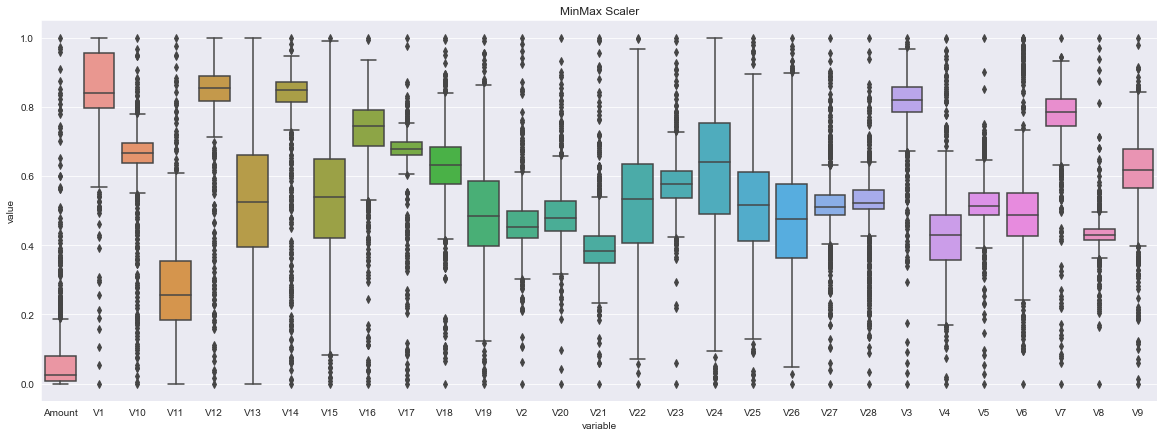

In [21]:
plt.figure(figsize = (20,7))
sns.boxplot(x = 'variable', y = 'value',data =df_mm.melt()).set_title('MinMax Scaler');

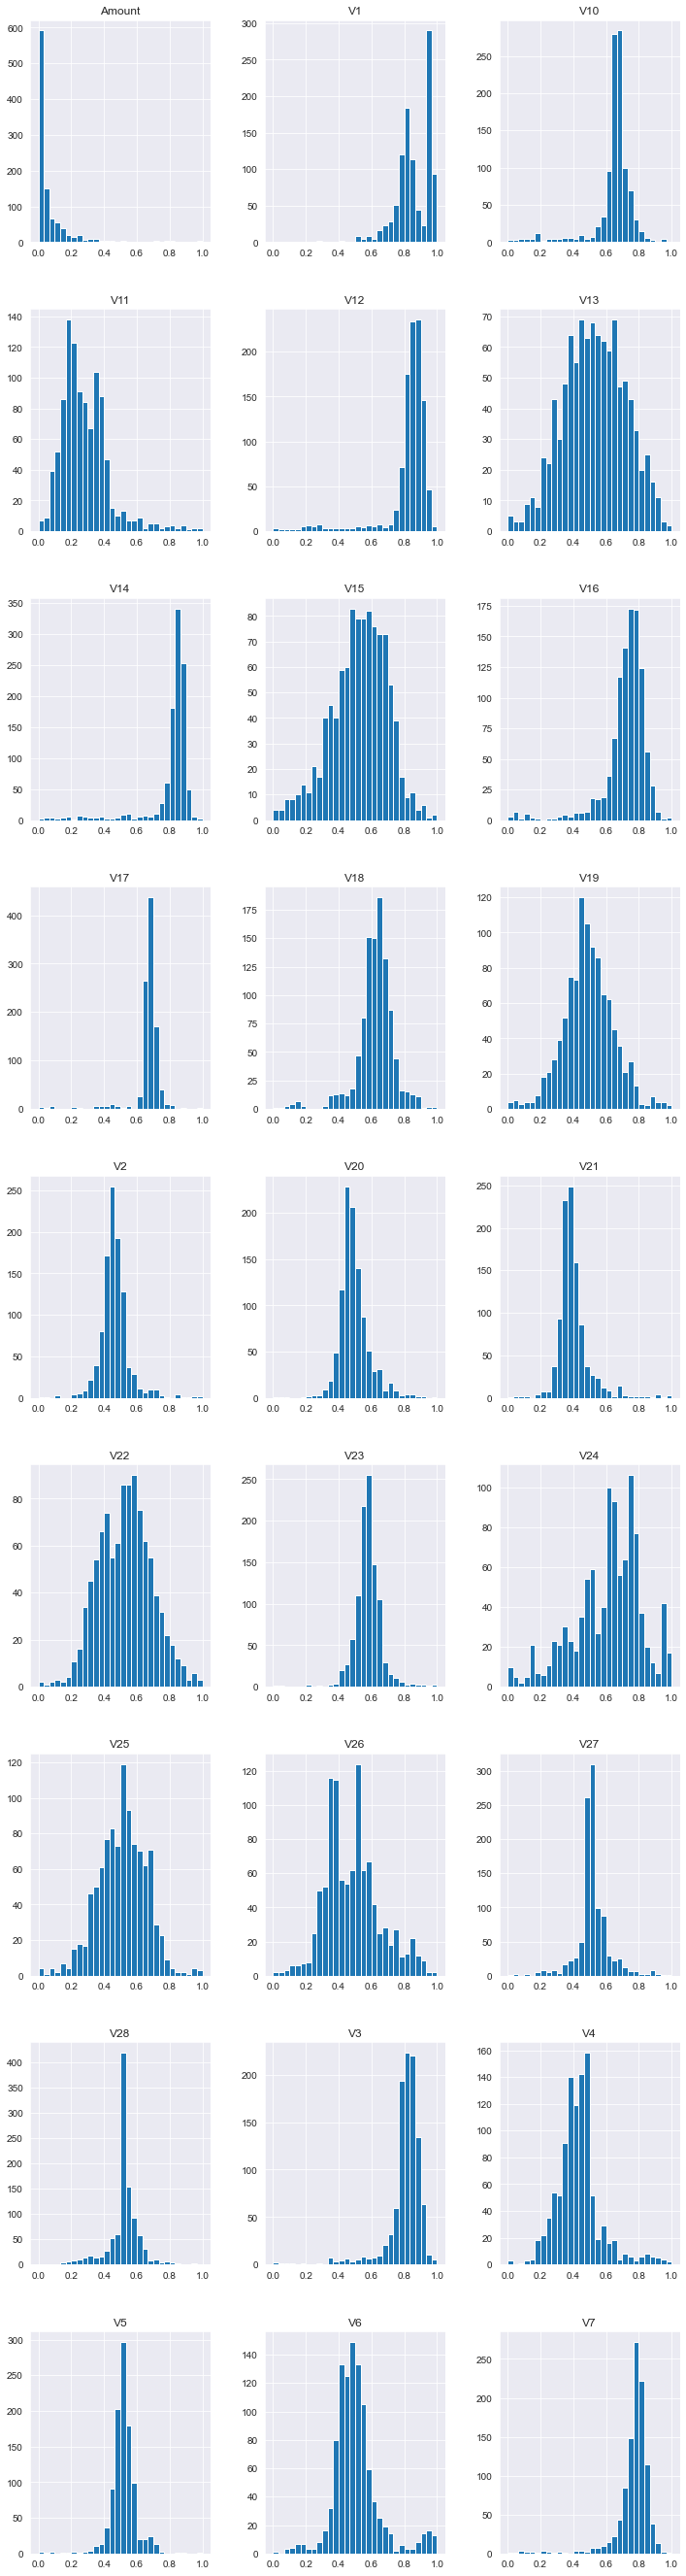

In [22]:
fig, axes = plt.subplots(len(df_mm.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_mm.hist(column = df_mm.columns[i], bins = 30, ax=axis)
        i = i+1
    

The skewness of the data seems to have reduced.

In [23]:
df_mm.shape

(1028, 29)

### 4.Separate the dependent and independent variables

In [24]:
#independent variables
X = df_mm
X.shape


(1028, 29)

In [25]:
#dependent variables
y = df['Class']
y.shape


(1028,)

### 5.Split training and testing data

In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [27]:

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (719, 29)
Number transactions y_train dataset:  (719,)
Number transactions X_test dataset:  (309, 29)
Number transactions y_test dataset:  (309,)


#### Apply Smote with oversampling for handling imbalabnced data

In [28]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 64
Before OverSampling, counts of label '0': 655 

After OverSampling, the shape of train_X: (1310, 29)
After OverSampling, the shape of train_y: (1310,) 

After OverSampling, counts of label '1': 655
After OverSampling, counts of label '0': 655


### 6. Base Model Building

We will use these models, to build our meta-model
- DecisionTreeClassifier
- K Nearest Neighbour
- Support Vector Machine
- Naive bayes
- XGBClassifier


In [29]:
#get a list of models to evaluate
def get_base_models():
    models = dict()
    models['cart'] = DecisionTreeClassifier()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['xg'] = XGBClassifier()
    return models


In [30]:
#evaluate a given model using cross-validation
#takes a model instance and returns a list of scores from three repeats of stratified 10-fold cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [31]:
#create the standalone base models for binary classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

models = get_base_models()
models

{'cart': DecisionTreeClassifier(),
 'lr': LogisticRegression(),
 'knn': KNeighborsClassifier(),
 'svm': SVC(),
 'bayes': GaussianNB(),
 'xg': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)}

In [32]:
# evaluate the models and store results

results = []
names = []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>cart 0.974 (0.018)
>lr 0.979 (0.015)
>knn 0.980 (0.014)
>svm 0.982 (0.014)
>bayes 0.954 (0.022)
>xg 0.983 (0.013)


We can see that XGBoost has performed the best with 98.3% accuracy.

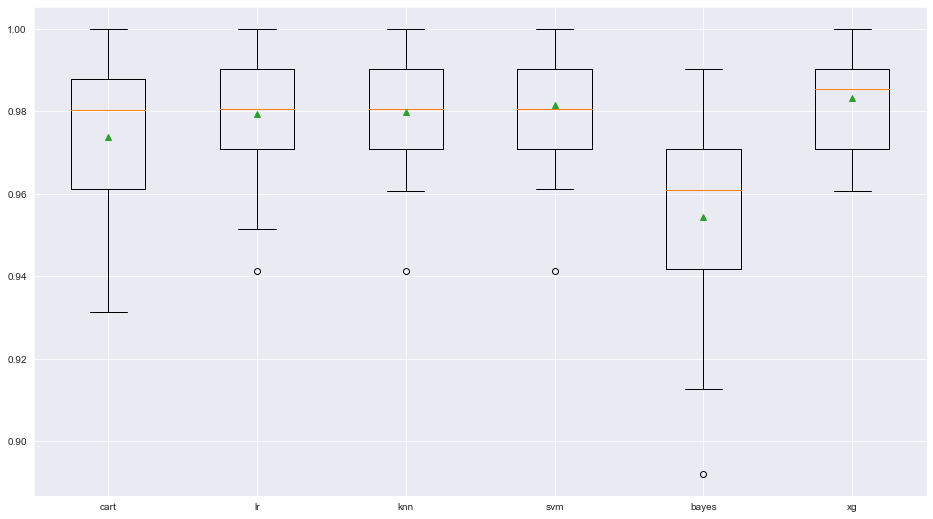

In [33]:
#report the mean performance of each algorithm and also create a box and whisker plot to compare 
#the distribution of accuracy scores for each algorithm.
plt.boxplot(results, labels=names, showmeans=True)
pyplot.show()


The plot also confirms that XG has the best performance.

### 7.Stacking

Next, we can try to combine these base models into a single ensemble model using stacking.

In [34]:
#combining models into one mode with the help of stacking.
#combining predictions of the base models using Random Forest
from sklearn.ensemble import StackingClassifier
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    level0.append(('xg', XGBClassifier(eval_metric='mlogloss')))

    # define meta learner model
    level1 = RandomForestClassifier()
    
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model



In [35]:
def get_models2():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['xg'] = XGBClassifier()
    models['stacking'] = get_stacking()
    return models


In [36]:
# get the models to evaluate
models = get_models2()
models 


{'lr': LogisticRegression(),
 'knn': KNeighborsClassifier(),
 'cart': DecisionTreeClassifier(),
 'svm': SVC(),
 'bayes': GaussianNB(),
 'xg': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'stacking': StackingClassifier(cv=5,
                    estimators=[('lr', LogisticRegression()),
                                ('knn', KNeighborsClassifier()),
                                ('cart', DecisionTre

In [37]:
#evaluate the models and store results
results = []
names = []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))



>lr 0.979 (0.015)
>knn 0.980 (0.014)
>cart 0.974 (0.020)
>svm 0.982 (0.014)
>bayes 0.954 (0.022)
>xg 0.983 (0.013)
>stacking 0.984 (0.012)


We can see that the stacking ensemble appears to perform better than any single model on average, achieving an accuracy of about 98.4 percent.

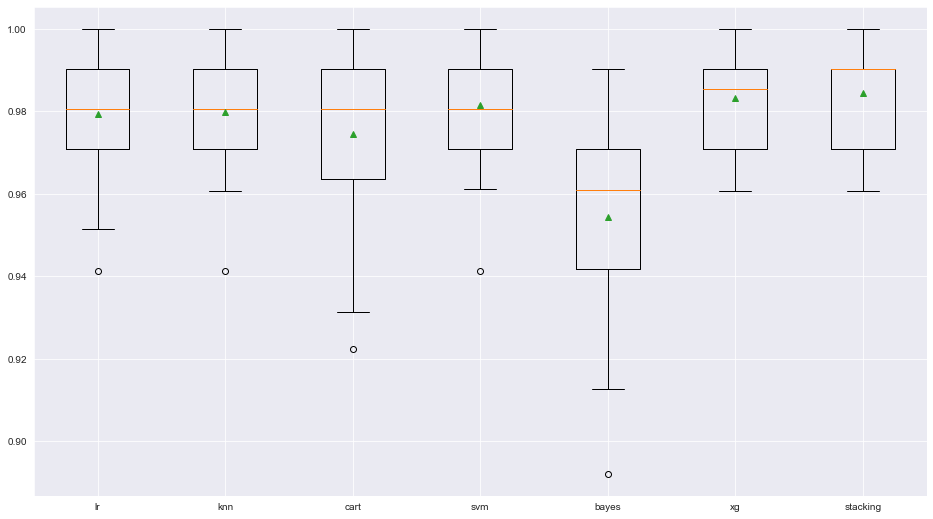

In [38]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In the plot, we can see that the mean and median accuracy for the stacking model sits slightly higher than the closest rival - XG model.

### 8. Create Final model on Train and Test and Evaluate results

In [39]:
stack = get_stacking()
stack

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()),
                               ('cart', DecisionTreeClassifier()),
                               ('svm', SVC()), ('bayes', GaussianNB()),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              eval_metric='mlogloss',
                                              gamma=None, gpu_id=None,
                                              importance_type='gain'...
                                              learning_rate=None,
                                              max_delta_step=None,
                                          

In [40]:
stack.fit(X_train, y_train).score(X_test, y_test)

0.9870550161812298

### Conclusion

The stacking classifier predicts with 98.7% accuracy, whether a credit transaction is fraudulent or not.